In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Install pyreadr library
#!pip install pyreadr
import pyreadr

#### Explanation of Imported Libraries

- **NumPy (`numpy`)**: Provides support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays.
- **pandas**: Essential for data manipulation and analysis, offering data structures and operations for manipulating numerical tables and time series.
- **matplotlib** and **seaborn**: Used for creating static, interactive, and animated visualizations in Python.
- **scikit-learn (`sklearn`)**: A simple and efficient tool for predictive data analysis. It integrates a wide range of machine learning algorithms for medium-scale supervised and unsupervised problems.
- **statsmodels**: Provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration.
- **pyreadr**: A package used to read R data files (like RDS and others) directly into Python without having to use R.


# Load the Data

We will read the data from .RDS files for each year from 2019 to 2023.

In [2]:
# Load data from RDS files for each year
data_2019 = pyreadr.read_r('2019_1min_df.RDS')[None]
data_2020 = pyreadr.read_r('2020_1min_df.RDS')[None]
data_2021 = pyreadr.read_r('2021_1min_df.RDS')[None]
data_2022 = pyreadr.read_r('2022_1min_df.RDS')[None]
data_2023 = pyreadr.read_r('2023_1min_df.RDS')[None]

# Merge all the dataframes into a single dataframe
df = pd.concat([data_2019, data_2020, data_2021, data_2022, data_2023], ignore_index=True)

# Convert 'datetime_utc' to datetime format and sort the dataframe by this column
df['datetime_utc'] = pd.to_datetime(df['datetime_utc'])
df.sort_values(by='datetime_utc', inplace=True)

# Fill any missing values using forward fill and backward fill
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

# Display the shape of the dataframe
print(df.shape)

(2629440, 10)


Here, the `pyreadr` library is used to load `.RDS` files, a format native to the R programming language. This is essential for ensuring that data structured and saved in R can be seamlessly transferred and used in Python for further analysis.

In [3]:
# Display the columns of the dataframe
print(df.columns)

Index(['datetime_utc', 'datetime_stamp', 'Wells_Total_Discharge',
       'Chelan_Flow', 'Entiat_Flow', 'Rocky_Reach_Total_Discharge',
       'Wenatchee_Flow', 'Rock_Island_Total_Discharge',
       'Rock_Island_Headwater_Elevation', 'Rocky_Reach_Headwater_Elevation'],
      dtype='object')


# 1. Rocky Reach

## 1.1. Traditional Model for Headwater Elevation Changes based on Fill Rate

### 1.1.1. Rocky Reach Inflow Calculation

We will calculate the Rocky Reach Inflow based on the flow impacts from Wells, Chelan, and Entiat. The impacts are calculated using moving averages and shifted data.


Wells Flow Impact = flows averaged from previous 90-105 minutes

Chelan Flow Impact = flows averaged from previous 62-77 minutes (60-75 should be fine)

Entiat Flow Impact = flows averaged from previous 15-30 minutes

Rocky Reach Inflow = Wells Flow Impact + Chelan Flow Impact + Entiat Flow Impact

In [4]:
# Create a copy of the dataframe for Rocky Reach Dam calculations
df_rocky_reach = df.copy()

# Calculate Wells Flow Impact (flows averaged from previous 90-105 minutes)
df_rocky_reach['Wells_Flow_Impact'] = df_rocky_reach['Wells_Total_Discharge'].shift(105).rolling(window=16).mean()
df_rocky_reach['Wells_Flow_Impact'].fillna(method='bfill', inplace=True)

# Calculate Chelan Flow Impact (flows averaged from previous 62-77 minutes)
df_rocky_reach['Chelan_Flow_Impact'] = df_rocky_reach['Chelan_Flow'].shift(77).rolling(window=16).mean()
df_rocky_reach['Chelan_Flow_Impact'].fillna(method='bfill', inplace=True)

# Calculate Entiat Flow Impact (flows averaged from previous 15-30 minutes)
df_rocky_reach['Entiat_Flow_Impact'] = df_rocky_reach['Entiat_Flow'].shift(30).rolling(window=16).mean()
df_rocky_reach['Entiat_Flow_Impact'].fillna(method='bfill', inplace=True)

# Calculate Rocky Reach Inflow
df_rocky_reach['Rocky_Reach_Inflow'] = df_rocky_reach['Wells_Flow_Impact'] + df_rocky_reach['Chelan_Flow_Impact'] + df_rocky_reach['Entiat_Flow_Impact']

# Display the updated DataFrame
df_rocky_reach[['datetime_utc', 'Wells_Flow_Impact', 'Chelan_Flow_Impact', 'Entiat_Flow_Impact', 'Rocky_Reach_Inflow']].head()

datetime_utc  Wells_Flow_Impact  Chelan_Flow_Impact  \
0 2019-01-01 08:00:00+00:00          56.139926            2.387459   
1 2019-01-01 08:01:00+00:00          56.139926            2.387459   
2 2019-01-01 08:02:00+00:00          56.139926            2.387459   
3 2019-01-01 08:03:00+00:00          56.139926            2.387459   
4 2019-01-01 08:04:00+00:00          56.139926            2.387459   

   Entiat_Flow_Impact  Rocky_Reach_Inflow  
0                 0.0           58.527385  
1                 0.0           58.527385  
2                 0.0           58.527385  
3                 0.0           58.527385  
4                 0.0           58.527385

### 1.1.2. Calculate Rocky Reach Fill Rate

The fill rate is calculated as the difference between the Rocky Reach inflow and the total discharge.

In [5]:
# Calculate the Rocky Reach Fill Rate
df_rocky_reach['Rocky_Reach_Fill_Rate'] = df_rocky_reach['Rocky_Reach_Inflow'] - df_rocky_reach['Rocky_Reach_Total_Discharge']

# Display the updated DataFrame
df_rocky_reach[['Rocky_Reach_Fill_Rate']].head()

Rocky_Reach_Fill_Rate
0             -13.758636
1             -10.294244
2              -7.975250
3              -5.349238
4              -3.843683

### 1.1.3. Correlation Analysis

We will analyze the correlation between the Rocky Reach Fill Rate and the changes in headwater elevation.

In [6]:
# Calculate the change in Rocky Reach headwater elevation
df_rocky_reach['Rocky_Reach_Headwater_Elevation_Change'] = df_rocky_reach['Rocky_Reach_Headwater_Elevation'].diff()
df_rocky_reach['Rocky_Reach_Headwater_Elevation_Change'].fillna(method='ffill', inplace=True)
df_rocky_reach['Rocky_Reach_Headwater_Elevation_Change'].fillna(method='bfill', inplace=True)

# Calculate the correlation between Rocky Reach Fill Rate and Headwater Elevation Change
rocky_reach_correlation = df_rocky_reach['Rocky_Reach_Fill_Rate'].corr(df_rocky_reach['Rocky_Reach_Headwater_Elevation_Change'])
print(f'Correlation between Rocky Reach Fill Rate and Headwater Elevation Change: {rocky_reach_correlation}')

Correlation between Rocky Reach Fill Rate and Headwater Elevation Change: 0.049554113412798355


### 1.1.4. Linear Regression Model for Headwater Elevation Changes

We will build a linear regression model to predict the headwater elevation changes based on the fill rate.

- **Linear Regression**: A basic and commonly used type of predictive analysis which assumes a linear relationship between input variables (x) and the output variable (y). It is used here to predict continuous values.

In [7]:
# Prepare data for modeling for Rocky Reach Dam
X_rocky_reach = df_rocky_reach[['Rocky_Reach_Fill_Rate']]
y_rocky_reach = df_rocky_reach['Rocky_Reach_Headwater_Elevation_Change']

# Split the data into training and testing sets
X_train_rocky_reach, X_test_rocky_reach, y_train_rocky_reach, y_test_rocky_reach = train_test_split(
    X_rocky_reach, y_rocky_reach, test_size=0.3, shuffle=False
)

# Create a linear regression model for Rocky Reach Dam
model_rocky_reach = LinearRegression()

# Train the model for Rocky Reach Dam
model_rocky_reach.fit(X_train_rocky_reach, y_train_rocky_reach)

# Make predictions on the test set for Rocky Reach Dam
y_pred_rocky_reach = model_rocky_reach.predict(X_test_rocky_reach)

# Evaluate the model for Rocky Reach Dam
mse_rocky_reach = mean_squared_error(y_test_rocky_reach, y_pred_rocky_reach)
r2_rocky_reach = r2_score(y_test_rocky_reach, y_pred_rocky_reach)

print(f'Mean Squared Error for Rocky Reach Dam: {mse_rocky_reach}')
print(f'R-squared for Rocky Reach Dam: {r2_rocky_reach}')

Mean Squared Error for Rocky Reach Dam: 0.0013856120992723096
R-squared for Rocky Reach Dam: 0.002592150329449594


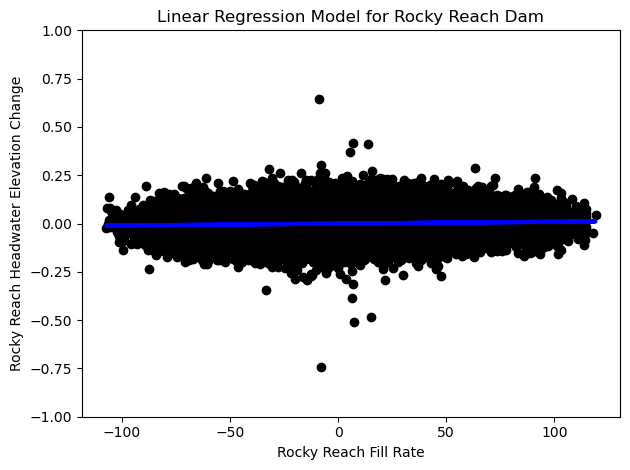

In [8]:
# Plot the regression line for Rocky Reach Dam
plt.scatter(X_test_rocky_reach, y_test_rocky_reach, color='black')
plt.plot(X_test_rocky_reach, y_pred_rocky_reach, color='blue', linewidth=3)
plt.title('Linear Regression Model for Rocky Reach Dam')
plt.xlabel('Rocky Reach Fill Rate')
plt.ylabel('Rocky Reach Headwater Elevation Change')

# Set y-axis limits
plt.ylim(-1, 1)

plt.tight_layout()
plt.show()

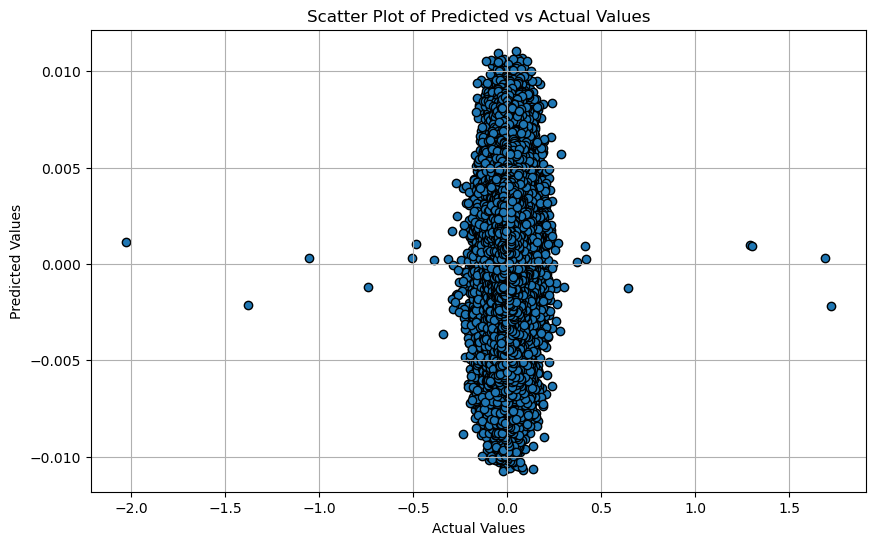

In [9]:
# Scatter plot of predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_rocky_reach, y_pred_rocky_reach, edgecolors='k')
plt.title('Scatter Plot of Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

## 1.2. Traditional Model for Headwater Elevation based on Fill Rate

We will build another linear regression model to predict the headwater elevation based on the fill rate.

In [10]:
# Calculate the correlation between Rocky Reach Fill Rate and Headwater Elevation
rocky_reach_correlation = df_rocky_reach['Rocky_Reach_Fill_Rate'].corr(df_rocky_reach['Rocky_Reach_Headwater_Elevation'])
print(f'Correlation between Rocky Reach Fill Rate and Headwater Elevation: {rocky_reach_correlation}')

Correlation between Rocky Reach Fill Rate and Headwater Elevation: 0.24607543728421355


In [11]:
# Prepare data for modeling for Rocky Reach Dam
X_rocky_reach = df_rocky_reach[['Rocky_Reach_Fill_Rate']]
y_rocky_reach = df_rocky_reach['Rocky_Reach_Headwater_Elevation']

# Split the data into training and testing sets
X_train_rocky_reach, X_test_rocky_reach, y_train_rocky_reach, y_test_rocky_reach = train_test_split(
    X_rocky_reach, y_rocky_reach, test_size=0.3, shuffle=False
)

# Create a linear regression model for Rocky Reach Dam
model_rocky_reach = LinearRegression()

# Train the model for Rocky Reach Dam
model_rocky_reach.fit(X_train_rocky_reach, y_train_rocky_reach)

# Make predictions on the test set for Rocky Reach Dam
y_pred_rocky_reach = model_rocky_reach.predict(X_test_rocky_reach)

# Evaluate the model for Rocky Reach Dam
mse_rocky_reach = mean_squared_error(y_test_rocky_reach, y_pred_rocky_reach)
r2_rocky_reach = r2_score(y_test_rocky_reach, y_pred_rocky_reach)

print(f'Mean Squared Error for Rocky Reach Dam: {mse_rocky_reach}')
print(f'R-squared for Rocky Reach Dam: {r2_rocky_reach}')

Mean Squared Error for Rocky Reach Dam: 0.4345206911200416
R-squared for Rocky Reach Dam: 0.01194513380333928


We will visualize the results of our linear regression model for headwater elevation.

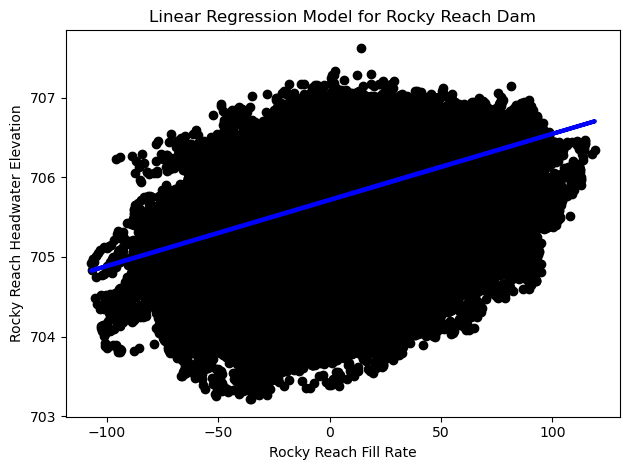

In [12]:
# Plot the regression line for Rocky Reach Dam
plt.scatter(X_test_rocky_reach, y_test_rocky_reach, color='black')
plt.plot(X_test_rocky_reach, y_pred_rocky_reach, color='blue', linewidth=3)
plt.title('Linear Regression Model for Rocky Reach Dam')
plt.xlabel('Rocky Reach Fill Rate')
plt.ylabel('Rocky Reach Headwater Elevation')

plt.tight_layout()
plt.show()

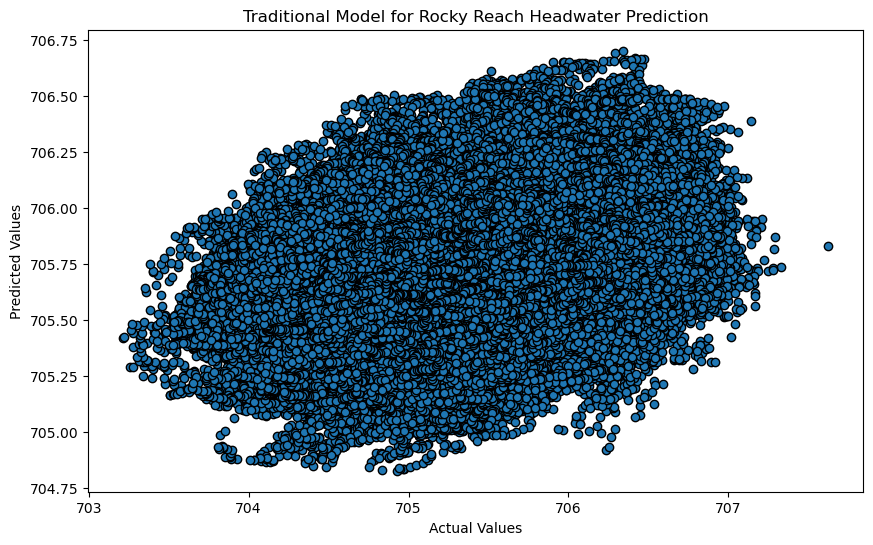

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_rocky_reach, y_pred_rocky_reach, edgecolors='k')
plt.title('Traditional Model for Rocky Reach Headwater Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

## 1.3. Traditional Method for Headwater Elevation based on Wells Flow Impact, Chelan Flow Impact and Entiat Flow Impact

We will build a model using the impacts from Wells, Chelan, and Entiat flows to predict headwater elevation.

In [14]:
# Prepare data for modeling for Rocky Reach Dam
X_rocky_reach = df_rocky_reach[['Wells_Flow_Impact','Chelan_Flow_Impact','Entiat_Flow_Impact']]
y_rocky_reach = df_rocky_reach['Rocky_Reach_Headwater_Elevation']

# Split the data into training and testing sets
X_train_rocky_reach, X_test_rocky_reach, y_train_rocky_reach, y_test_rocky_reach = train_test_split(
    X_rocky_reach, y_rocky_reach, test_size=0.3, shuffle=False
)

# Create a linear regression model for Rocky Reach Dam
model_rocky_reach = LinearRegression()

# Train the model for Rocky Reach Dam
model_rocky_reach.fit(X_train_rocky_reach, y_train_rocky_reach)

# Make predictions on the test set for Rocky Reach Dam
y_pred_rocky_reach = model_rocky_reach.predict(X_test_rocky_reach)

# Evaluate the model for Rocky Reach Dam
mse_rocky_reach = mean_squared_error(y_test_rocky_reach, y_pred_rocky_reach)
r2_rocky_reach = r2_score(y_test_rocky_reach, y_pred_rocky_reach)

print(f'Mean Squared Error for Rocky Reach Dam: {mse_rocky_reach}')
print(f'R-squared for Rocky Reach Dam: {r2_rocky_reach}')

Mean Squared Error for Rocky Reach Dam: 0.3714218213121386
R-squared for Rocky Reach Dam: 0.15542540215259615


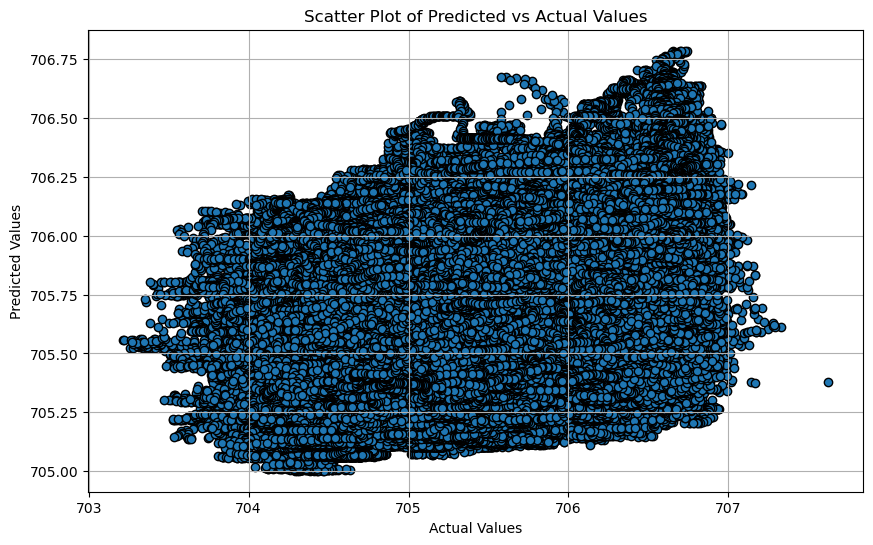

In [15]:
# Scatter plot of predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_rocky_reach, y_pred_rocky_reach, edgecolors='k')
plt.title('Scatter Plot of Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

## 1.4. Headwater Elevation based on Feature Engineering and Feature Selection Using PCA

We will engineer additional features, apply PCA for dimensionality reduction, and build a regression model.

### 1.4.1 Feature Engineering

Feature engineering is a crucial step in the data preprocessing phase where existing raw features are transformed or new features are created to improve the performance of machine learning models. This process can involve several techniques such as normalization, standardization, encoding categorical variables, and creating interaction terms among features, which helps in making the data more suitable for modeling.

In [16]:
### 1.4.1. Feature Engineering
# Create a copy of the dataframe for feature engineering
df_rocky_reach = df.copy()

# Rocky Reach Headwater Elevation lag for last 2 minutes
for lag in range(1, 3):
    df_rocky_reach[f'Rocky_Reach_Headwater_Elevation_lag_{lag}'] = df_rocky_reach['Rocky_Reach_Headwater_Elevation'].shift(lag)

# Rocky Reach Discharge lag for last 2 minutes
for lag in range(1, 3):
    df_rocky_reach[f'Rocky_Reach_Total_Discharge_lag_{lag}'] = df_rocky_reach['Rocky_Reach_Total_Discharge'].shift(lag)

# Wells Flow Impact = flows averaged from previous 90-105 minutes
for lag in range(90, 106):
    df_rocky_reach[f'Wells_Total_Discharge_lag_{lag}'] = df_rocky_reach['Wells_Total_Discharge'].shift(lag)

# Chelan Flow Impact = flows averaged from previous 62-77 minutes (60-75 should be fine)
for lag in range(62, 78):
    df_rocky_reach[f'Chelan_Flow_lag_{lag}'] = df_rocky_reach['Chelan_Flow'].shift(lag)

# Entiat Flow Impact = flows averaged from previous 15-30 minutes
for lag in range(15, 31):
    df_rocky_reach[f'Entiat_Flow_lag_{lag}'] = df_rocky_reach['Entiat_Flow'].shift(lag)

# List of unnecessary columns to drop
columns_to_drop = ['datetime_utc', 'datetime_stamp', 'Wells_Total_Discharge','Chelan_Flow', 'Entiat_Flow', 
                   'Wenatchee_Flow', 'Rock_Island_Total_Discharge', 'Rock_Island_Headwater_Elevation']

# Drop the unnecessary columns
df_rocky_reach = df_rocky_reach.drop(columns=columns_to_drop).copy()

# Drop rows with missing values
df_rocky_reach.dropna(inplace=True)

# Display the shape of the dataframe
print(df_rocky_reach.shape)

(2629335, 54)


### 1.4.2. Feature Selection Using PCA and Modeling

We will use PCA to reduce the dimensionality of the data and then build a regression model.

Principal Component Analysis (PCA) is a statistical technique used for dimensionality reduction while maintaining most of the important information. PCA achieves this by identifying the directions (principal components) along which the variance of the data is maximized. This is particularly useful in processing and visualizing high-dimensional data, simplifying the complexity in data by converting it into smaller dimensions (principal components), which still contain most of the information.

In [17]:
# Separate features and target
target = 'Rocky_Reach_Headwater_Elevation'
X = df_rocky_reach.drop(columns=[target]) 
y = df_rocky_reach[target]  # Target

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Running the above code gives 16 optimal components

### 1.4.3. PCA Model Training and Evaluation

In [19]:
# Set up PCA with the optimal number of components
pca = PCA(n_components=16)
X_pca = pca.fit_transform(X)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, shuffle=False)

# Model training with Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print("Mean Squared Error for Rocky Reach Dam:", mean_squared_error(y_test, y_pred))
print("R-Squared for Rocky Reach Dam:", r2_score(y_test, y_pred))

Mean Squared Error for Rocky Reach Dam: 0.00251595302614246
R-Squared for Rocky Reach Dam: 0.9942786545677524


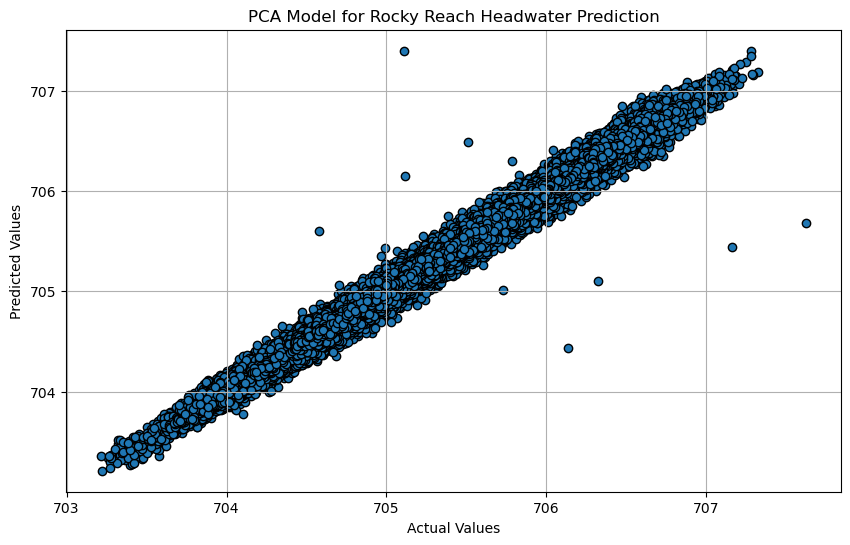

In [20]:
# Scatter plot of predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, edgecolors='k')
plt.title('PCA Model for Rocky Reach Headwater Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

### 1.4.4. Comparison of Traditional and PCA Models

We will compare the traditional model and PCA model predictions.

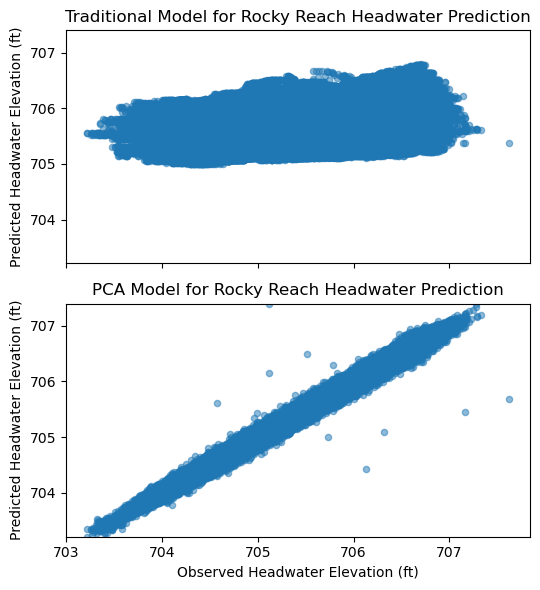

In [21]:
import matplotlib.pyplot as plt

# Create a figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5.5, 6))

# Traditional Model
ax1.scatter(y_test_rocky_reach, y_pred_rocky_reach, s=20, alpha=0.5)
ax1.set_title('Traditional Model for Rocky Reach Headwater Prediction')
ax1.set_ylabel('Predicted Headwater Elevation (ft)')

# PCA Model
ax2.scatter(y_test, y_pred, s=20, alpha=0.5)
ax2.set_title('PCA Model for Rocky Reach Headwater Prediction')
ax2.set_xlabel('Observed Headwater Elevation (ft)')  # Shared x-axis label
ax2.set_ylabel('Predicted Headwater Elevation (ft)')

# Determine consistent y-limits
all_predicted_values = list(y_pred_rocky_reach) + list(y_pred)  # Combine predicted values
y_min = min(all_predicted_values)  # Find minimum
y_max = max(all_predicted_values)  # Find maximum

# Apply consistent y-limits to both subplots
ax1.set_ylim([y_min, y_max])
ax2.set_ylim([y_min, y_max])

# Remove extra x-axis label and tick labels from the first subplot
ax1.tick_params(labelbottom=False)

# Tight layout to adjust spacing
plt.tight_layout()

plt.show()

### 1.4.5. Most Influential Features in PCA

We will identify the most influential features in the PCA components.

In [22]:
# Features from the data
feature_names = X.columns

# Components given by pca
components = pca.components_

# Function to get top features for each component
def get_top_features_for_component(component, num_features):
    sorted_feature_indices = np.argsort(np.abs(component))[::-1][:num_features]
    return feature_names[sorted_feature_indices]

# Getting top 10 features for each component
num_top_features = 10 
top_features_per_component = {}

for i, component in enumerate(components):
    top_features = get_top_features_for_component(component, num_top_features)
    top_features_per_component[f"Component {i+1}"] = top_features

# Counting how often each feature appears in the top lists
feature_counts = pd.Series(np.concatenate(list(top_features_per_component.values()))).value_counts()

# Displaying the most frequently appearing features
print("Most Influential Features in PCA:")
print(feature_counts.head(10))

Most Influential Features in PCA:
Wells_Total_Discharge_lag_101    10
Wells_Total_Discharge_lag_98     10
Wells_Total_Discharge_lag_97      9
Wells_Total_Discharge_lag_105     9
Wells_Total_Discharge_lag_90      9
Wells_Total_Discharge_lag_102     9
Wells_Total_Discharge_lag_93      9
Wells_Total_Discharge_lag_96      9
Wells_Total_Discharge_lag_94      8
Wells_Total_Discharge_lag_100     8
Name: count, dtype: int64


### 1.4.6. Final Model Coefficients

We will map the final contributions of the original features in the PCA-based regression model.

In [24]:
pca_components = pca.components_
regression_coefficients = model.coef_
intercept = model.intercept_

# Calculate contributions of original features
n_features = X.shape[1]
feature_contributions = np.zeros(n_features)
for i in range(pca.n_components_):
    feature_contributions += pca.components_[i, :] * regression_coefficients[i]

# Adjust for original feature scaling
feature_contributions *= scaler.scale_

# Final contributions including the intercept
final_contributions = np.concatenate(([intercept], feature_contributions))

# Mapping contributions back to feature names
feature_names = ['Intercept'] + list(X.columns)
final_model_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': final_contributions})
final_model_df

Feature  Coefficient
0                               Intercept   705.698892
1             Rocky_Reach_Total_Discharge    -0.313188
2   Rocky_Reach_Headwater_Elevation_lag_1     0.341014
3   Rocky_Reach_Headwater_Elevation_lag_2     0.340845
4       Rocky_Reach_Total_Discharge_lag_1    -0.230899
5       Rocky_Reach_Total_Discharge_lag_2     0.535095
6            Wells_Total_Discharge_lag_90    -0.217575
7            Wells_Total_Discharge_lag_91     0.481417
8            Wells_Total_Discharge_lag_92    -0.301355
9            Wells_Total_Discharge_lag_93    -0.117960
10           Wells_Total_Discharge_lag_94     0.420582
11           Wells_Total_Discharge_lag_95    -0.315917
12           Wells_Total_Discharge_lag_96    -0.052519
13           Wells_Total_Discharge_lag_97     0.415128
14           Wells_Total_Discharge_lag_98    -0.371952
15           Wells_Total_Discharge_lag_99    -0.004333
16          Wells_Total_Discharge_lag_100     0.391348
17          Wells_Total_Discharge_lag_101    -0.443637
18          Wells_Total_Discharge_lag_102     0.075251
19          Wells_Total_Discharge_lag_103     0.428315
20          Wells_Total_Discharge_lag_104    -0.599379
21          Wells_Total_Discharge_lag_105     0.222585
22                     Chelan_Flow_lag_62     0.000765
23                     Chelan_Flow_lag_63     0.000677
24                     Chelan_Flow_lag_64     0.000592
25                     Chelan_Flow_lag_65     0.000502
26                     Chelan_Flow_lag_66     0.000405
27                     Chelan_Flow_lag_67     0.000304
28                     Chelan_Flow_lag_68     0.000198
29                     Chelan_Flow_lag_69     0.000089
30                     Chelan_Flow_lag_70    -0.000025
31                     Chelan_Flow_lag_71    -0.000144
32                     Chelan_Flow_lag_72    -0.000267
33                     Chelan_Flow_lag_73    -0.000391
34                     Chelan_Flow_lag_74    -0.000513
35                     Chelan_Flow_lag_75    -0.000632
36                     Chelan_Flow_lag_76    -0.000749
37                     Chelan_Flow_lag_77    -0.000867
38                     Entiat_Flow_lag_15    -0.000004
39                     Entiat_Flow_lag_16    -0.000004
40                     Entiat_Flow_lag_17    -0.000004
41                     Entiat_Flow_lag_18    -0.000004
42                     Entiat_Flow_lag_19    -0.000004
43                     Entiat_Flow_lag_20    -0.000005
44                     Entiat_Flow_lag_21    -0.000005
45                     Entiat_Flow_lag_22    -0.000005
46                     Entiat_Flow_lag_23    -0.000005
47                     Entiat_Flow_lag_24    -0.000005
48                     Entiat_Flow_lag_25    -0.000005
49                     Entiat_Flow_lag_26    -0.000006
50                     Entiat_Flow_lag_27    -0.000006
51                     Entiat_Flow_lag_28    -0.000006
52                     Entiat_Flow_lag_29    -0.000006
53                     Entiat_Flow_lag_30    -0.000006

## 1.5. Feature Engineering and PCA by Separating 2023's Data to Check for Overfitting

### 1.5.1. Feature Engineering

In this section, we will prepare the dataset for PCA by creating lagged features and separating the data into training and evaluation sets.

In [25]:
# Feature Engineering for Rocky Reach Dam

# Create a copy of the dataframe
df_rocky_reach = df.copy()

# Create lag features for Rocky Reach Headwater Elevation and Total Discharge
for lag in range(1, 3):
    df_rocky_reach[f'Rocky_Reach_Headwater_Elevation_lag_{lag}'] = df_rocky_reach['Rocky_Reach_Headwater_Elevation'].shift(lag)
    df_rocky_reach[f'Rocky_Reach_Total_Discharge_lag_{lag}'] = df_rocky_reach['Rocky_Reach_Total_Discharge'].shift(lag)

# Create lag features for Wells, Chelan, and Entiat flows
for lag in range(90, 106):
    df_rocky_reach[f'Wells_Total_Discharge_lag_{lag}'] = df_rocky_reach['Wells_Total_Discharge'].shift(lag)

for lag in range(62, 78):
    df_rocky_reach[f'Chelan_Flow_lag_{lag}'] = df_rocky_reach['Chelan_Flow'].shift(lag)

for lag in range(15, 31):
    df_rocky_reach[f'Entiat_Flow_lag_{lag}'] = df_rocky_reach['Entiat_Flow'].shift(lag)

# Drop unnecessary columns
columns_to_drop = ['datetime_stamp', 'Wells_Total_Discharge', 'Chelan_Flow', 'Entiat_Flow', 
                   'Wenatchee_Flow', 'Rock_Island_Total_Discharge', 'Rock_Island_Headwater_Elevation']
df_rocky_reach = df_rocky_reach.drop(columns=columns_to_drop).copy()

# Drop rows with missing values
df_rocky_reach.dropna(inplace=True)

# Split the data into pre-2023 and 2023 datasets
df_rocky_reach_before_2023 = df_rocky_reach[df_rocky_reach['datetime_utc'].dt.year < 2023]
df_rocky_reach_2023 = df_rocky_reach[df_rocky_reach['datetime_utc'].dt.year == 2023]

# Drop datetime_utc column and check the results
df_rocky_reach_before_2023 = df_rocky_reach_before_2023.drop(columns=['datetime_utc']).copy()
df_rocky_reach_2023 = df_rocky_reach_2023.drop(columns=['datetime_utc']).copy()

# Check the results
print(df_rocky_reach_before_2023.shape)
print(df_rocky_reach_2023.shape)


(2103255, 54)
(525600, 54)


### 1.5.2. Feature Selection Using PCA and Modeling

In this section, we will use PCA to reduce the dimensionality of the data and then build a regression model.

Optimal Components found is 16.

In [35]:
# Separate features and target
target = 'Rocky_Reach_Headwater_Elevation'
X = df_rocky_reach_before_2023.drop(columns=[target]) 
y = df_rocky_reach_before_2023[target]  # Target

X.shape, y.shape

((2103255, 53), (2103255,))

In [36]:
# Set up PCA with the optimal number of components
pca = PCA(n_components=16)
X_pca = pca.fit_transform(X)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, shuffle=False)

# Model training with Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print("Mean Squared Error for Rocky Reach Dam:", mean_squared_error(y_test, y_pred))
print("R-Squared for Rocky Reach Dam:", r2_score(y_test, y_pred))

Mean Squared Error for Rocky Reach Dam: 0.001800867510393071
R-Squared for Rocky Reach Dam: 0.9954215427403923


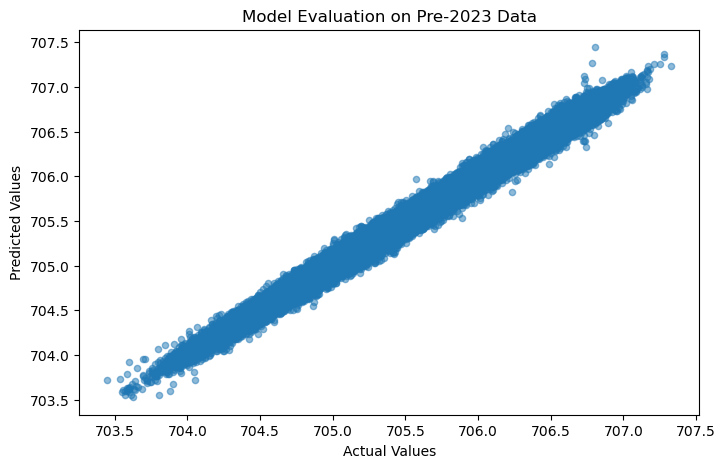

In [37]:
# Creating a scatter plot of predicted vs actual values
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, s=20, alpha=0.5)
plt.title("Model Evaluation on Pre-2023 Data")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

### 1.5.3 Model Evaluation on 2023's data

In this section, we will evaluate the model on the 2023 data to check for overfitting.

In [38]:
df_rocky_reach_2023.shape

(525600, 54)

In [39]:
target = 'Rocky_Reach_Headwater_Elevation'
X_eval = df_rocky_reach_2023.drop(columns=[target]) 
y_eval = df_rocky_reach_2023[target]  # Target

In [40]:
X_eval.shape, y_eval.shape

((525600, 53), (525600,))

In [41]:
X_eval_pca_corrected = pca.transform(X_eval)

y_pred = model.predict(X_eval_pca_corrected)
print("Mean Squared Error for Rocky Reach Dam:", mean_squared_error(y_eval, y_pred))
print("R-Squared for Rocky Reach Dam:", r2_score(y_eval, y_pred))

Mean Squared Error for Rocky Reach Dam: 0.0020836962133280188
R-Squared for Rocky Reach Dam: 0.9952821826560839


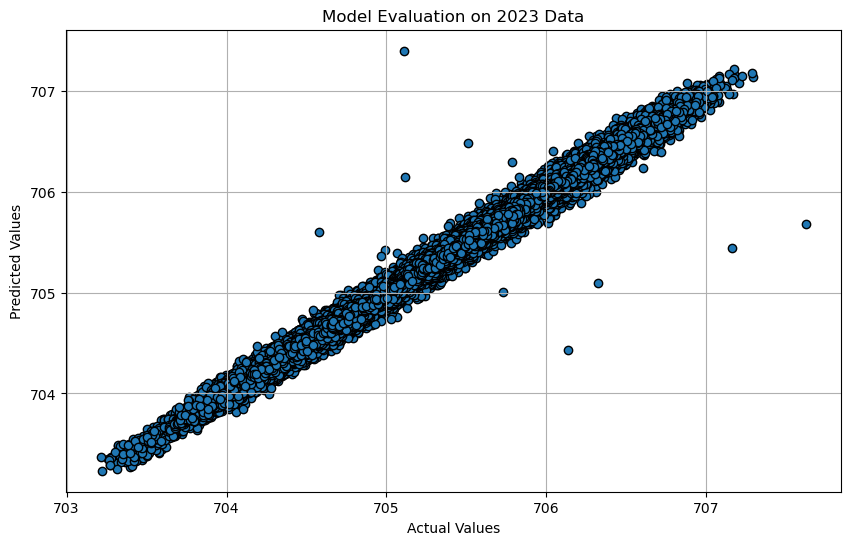

In [44]:
# Creating a scatter plot of predicted vs actual values for 2023 data
plt.figure(figsize=(10, 6))
plt.scatter(y_eval, y_pred, edgecolors='k')
plt.title('Model Evaluation on 2023 Data')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

## 1.6. Time Series Model for Forecasting January 2023's Headwater Elevation Based on Previous Data

In this section, we will build a time series model to forecast January 2023's headwater elevation.

Time series modeling is a method used to analyze time series data in order to extract meaningful statistics and characteristics about the data. It helps in forecasting future values based on previously observed values. Time series models are applicable in various real-world scenarios like economics, weather forecasting, stock market analysis, and more. In this notebook, specific time series models such as the Vector Autoregression (VAR) are utilized to capture the dynamics and seasonality of the data series.

In [45]:
df_rocky_reach = df.copy()
df_rocky_reach.shape

(2629440, 10)

In [46]:
# Prepare data for time series modeling
df_rocky_reach.set_index('datetime_utc', inplace=True)

# Filter data up to 2022 and for January 2023
train_data = df_rocky_reach[df_rocky_reach.index.year < 2023]
test_data = df_rocky_reach[df_rocky_reach.index.year == 2023]

# Focusing on relevant features
features = ['Wells_Total_Discharge', 'Chelan_Flow', 'Entiat_Flow', 'Rocky_Reach_Total_Discharge', 'Rocky_Reach_Headwater_Elevation']
train_data = train_data[features]
test_data = test_data[features]

### 1.6.1 Checking for Stationarity for Rocky Reach Headwater Elevation Using ADF Test

We will use the Augmented Dickey-Fuller (ADF) test to check for stationarity of the Rocky Reach headwater elevation.

In [47]:
# Calculate the number of samples for 1% of the data
sample_size = int(len(train_data) * 0.01)

# Select the last 1% of the data as a subset
subset_data = train_data[-sample_size:]

# Confirm the size of the subset
print(subset_data.shape)

(21033, 5)


In [48]:
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, perform an Augmented Dickey Fuller test
    and report the results.
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')  # Drop na values and calculate the diff
    
    labels = ['ADF test statistic', 'p-value', '# lags used', '# observations']
    out = pd.Series(result[0:4], index=labels)

    for key, value in result[4].items():
        out[f'critical value ({key})'] = value

    print(out.to_string())  # This prints out the full ADF report
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

# Apply the ADF test on the subset
adf_test(subset_data['Rocky_Reach_Headwater_Elevation'], 'Rocky Reach Headwater Elevation Subset')

Augmented Dickey-Fuller Test: Rocky Reach Headwater Elevation Subset
ADF test statistic         -5.550547
p-value                     0.000002
# lags used                46.000000
# observations          20986.000000
critical value (1%)        -3.430662
critical value (5%)        -2.861678
critical value (10%)       -2.566843
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Our data is stationary. So, we can use time series models

### 1.6.2. Modeling and Forecasting

#### Using VAR Model

The Vector Autoregression (VAR) model is a type of statistical model used in time series forecasting that captures the linear interdependencies among multiple time series. VAR models generalize the single-variable (univariate) autoregressive model by allowing for more than one evolving variable. All variables in a VAR model are treated symmetrically; each variable has an equation explaining its evolution based on its own lags and the lags of the other model variables. This model is particularly useful in multivariate time series data where the predictor variables are interrelated and influence each other.

In [41]:
# Model Building
model = VAR(train_data)
fitted_model = model.fit(maxlags= 60, ic= 'aic')

/Users/likhithaveganti/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)


In [42]:
# Forecasting
forecast_steps = len(test_data)
forecast = pd.DataFrame(
    fitted_model.forecast(
        train_data.values[-fitted_model.k_ar:], 
        steps=forecast_steps), 
    index=test_data.index, 
    columns=test_data.columns)

In [43]:
actual = test_data['Rocky_Reach_Headwater_Elevation']
predicted = forecast['Rocky_Reach_Headwater_Elevation']

# Compute MSE and R-squared
mse = mean_squared_error(actual, predicted)
r2 = r2_score(actual, predicted)

print("Mean Squared Error for Rocky Reach Dam:", mse)
print("R-Squared for Rocky Reach Dam:", r2)

Mean Squared Error for Rocky Reach Dam: 0.49900964859085645
R-Squared for Rocky Reach Dam: -0.12983666229506308


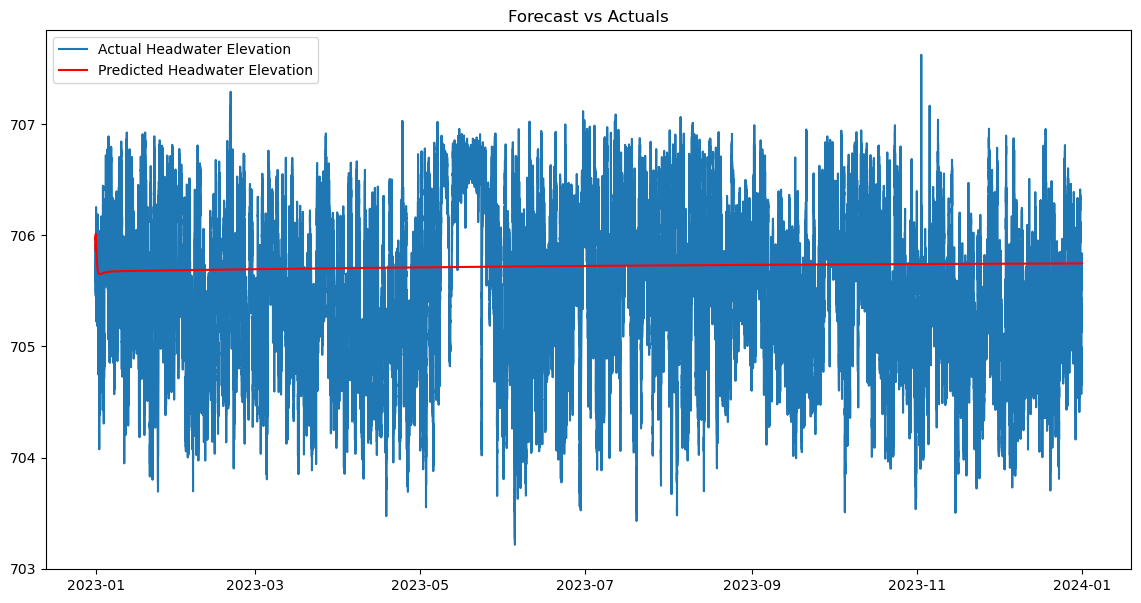

In [44]:
# Visualization
plt.figure(figsize=(14, 7))
plt.plot(test_data['Rocky_Reach_Headwater_Elevation'], label='Actual Headwater Elevation')
plt.plot(forecast['Rocky_Reach_Headwater_Elevation'], label='Predicted Headwater Elevation', color='red')
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()

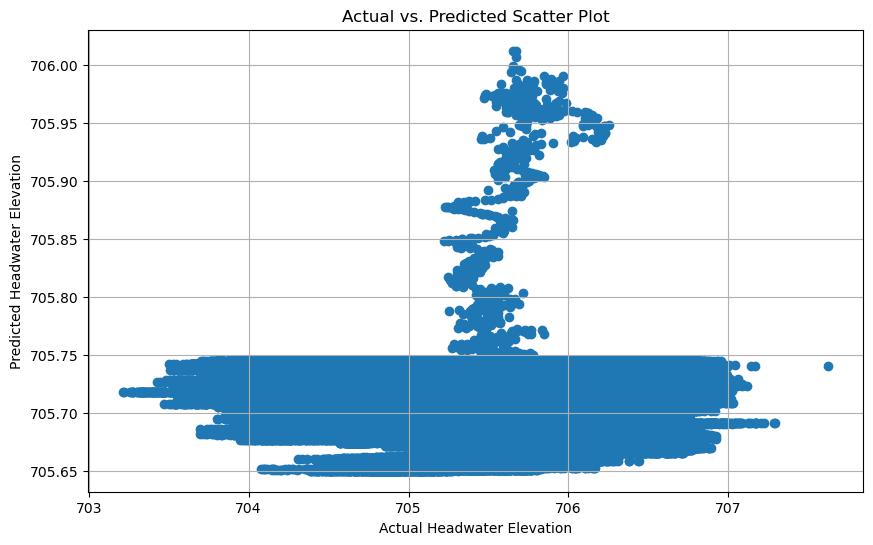

In [45]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(test_data['Rocky_Reach_Headwater_Elevation'], forecast['Rocky_Reach_Headwater_Elevation'])
plt.xlabel('Actual Headwater Elevation')
plt.ylabel('Predicted Headwater Elevation')
plt.title('Actual vs. Predicted Scatter Plot')
plt.grid(True)
plt.show()

## 1.7. Weather Data Integration

In this section, we will integrate weather data and analyze its impact on Rocky Reach headwater elevation.

In [184]:
df_rocky_reach = df.copy()

columns_to_drop = ['datetime_stamp', 'Wenatchee_Flow', 'Rock_Island_Total_Discharge', 'Rock_Island_Headwater_Elevation']

# Drop the unnecessary columns
df_rocky_reach = df_rocky_reach.drop(columns=columns_to_drop).copy()

df_rocky_reach.shape

(2629440, 6)

In [185]:
# Load and preprocess weather data
weather_data = pd.read_csv('weather.csv')

# Parse the 'full_date' column as datetime
weather_data['datetime'] = pd.to_datetime(weather_data['full_date'], format='%m/%d/%y %H:%M')

# Drop unnecessary columns
columns_to_drop = ['YEAR', 'MO', 'DY', 'date', 'full_date', 'HR']
weather_data.drop(columns=columns_to_drop, inplace=True)
weather_data.columns

Index(['Temperature(degC)', 'Humidity(g/kg)', 'Wind_Speed(m/s)', 'datetime'], dtype='object')

In [186]:
weather_data.shape

(28896, 4)

In [187]:
 # Convert 'datetime_utc' to datetime format if not already done
df_rocky_reach['datetime_utc'] = pd.to_datetime(df_rocky_reach['datetime_utc'])

# Check minimum and maximum dates in the dataset
rocky_reach_start_date = df_rocky_reach['datetime_utc'].min()
rocky_reach_end_date = df_rocky_reach['datetime_utc'].max()

# Display the start and end dates
print("Rocky Reach Dataset Start Date:", rocky_reach_start_date)
print("Rocky Reach Dataset End Date:", rocky_reach_end_date)

Rocky Reach Dataset Start Date: 2019-01-01 08:00:00+00:00
Rocky Reach Dataset End Date: 2024-01-01 07:59:00+00:00


In [188]:
# Check minimum and maximum dates in the dataset
weather_data_start_date = weather_data['datetime'].min()
weather_data_end_date = weather_data['datetime'].max()

# Display the start and end dates
print("Weather Dataset Start Date:", weather_data_start_date)
print("Weather Dataset End Date:", weather_data_end_date)

Weather Dataset Start Date: 2020-12-31 16:00:00
Weather Dataset End Date: 2024-04-18 15:00:00


In [189]:
# Set the datetime index for both datasets
df_rocky_reach.set_index('datetime_utc', inplace=True)
weather_data.set_index('datetime', inplace=True)

# Remove timezone information from df_rocky_reach if it's timezone-aware
if df_rocky_reach.index.tz is not None:
    df_rocky_reach.index = df_rocky_reach.index.tz_localize(None)

# Similarly, ensure weather_data is also timezone-naive
if weather_data.index.tz is not None:
    weather_data.index = weather_data.index.tz_localize(None)

# Calculate rolling averages for the past 1 hour
rolling_columns = ['Rocky_Reach_Total_Discharge', 'Wells_Total_Discharge', 'Chelan_Flow', 'Entiat_Flow']
for column in rolling_columns:
    df_rocky_reach[f'{column}_1hr_avg'] = df_rocky_reach[column].rolling(window='1H', min_periods=1).mean()

# Drop original columns to keep only the averages if that's desired
df_rocky_reach.drop(columns=rolling_columns, inplace=True)

# Ensure both dataframes are resampled to hourly data, this aligns both time series on the hour
df_rocky_reach = df_rocky_reach.resample('H').mean()
weather_data = weather_data.resample('H').mean()

# Merge the datasets on their index (datetime)
data = pd.merge(df_rocky_reach, weather_data, left_index=True, right_index=True, how='inner')
data

Rocky_Reach_Headwater_Elevation  \
2020-12-31 16:00:00                       704.290417   
2020-12-31 17:00:00                       704.429774   
2020-12-31 18:00:00                       704.402409   
2020-12-31 19:00:00                       704.363106   
2020-12-31 20:00:00                       704.624964   
...                                              ...   
2024-01-01 03:00:00                       704.974359   
2024-01-01 04:00:00                       704.797767   
2024-01-01 05:00:00                       704.591913   
2024-01-01 06:00:00                       704.519386   
2024-01-01 07:00:00                       704.671742   

                     Rocky_Reach_Total_Discharge_1hr_avg  \
2020-12-31 16:00:00                            76.922772   
2020-12-31 17:00:00                            71.214329   
2020-12-31 18:00:00                            66.731343   
2020-12-31 19:00:00                            68.235094   
2020-12-31 20:00:00                            68.075052   
...                                                  ...   
2024-01-01 03:00:00                           132.855839   
2024-01-01 04:00:00                           131.325456   
2024-01-01 05:00:00                           136.411705   
2024-01-01 06:00:00                           127.587544   
2024-01-01 07:00:00                           109.709080   

                     Wells_Total_Discharge_1hr_avg  Chelan_Flow_1hr_avg  \
2020-12-31 16:00:00                      82.402736             2.419326   
2020-12-31 17:00:00                      71.975435             2.422676   
2020-12-31 18:00:00                      71.068418             2.426025   
2020-12-31 19:00:00                      73.542640             2.429374   
2020-12-31 20:00:00                      75.226945             2.432724   
...                                            ...                  ...   
2024-01-01 03:00:00                     126.214008             0.846298   
2024-01-01 04:00:00                     117.435944             0.843956   
2024-01-01 05:00:00                     115.033537             0.836624   
2024-01-01 06:00:00                     110.075867             0.826182   
2024-01-01 07:00:00                      97.114470             0.819126   

                     Entiat_Flow_1hr_avg  Temperature(degC)  Humidity(g/kg)  \
2020-12-31 16:00:00             0.172000              -0.15            3.72   
2020-12-31 17:00:00             0.172000              -1.29            3.54   
2020-12-31 18:00:00             0.172000              -1.76            3.48   
2020-12-31 19:00:00             0.172000              -1.95            3.48   
2020-12-31 20:00:00             0.170855              -2.01            3.48   
...                                  ...                ...             ...   
2024-01-01 03:00:00             0.182000              -1.99            3.54   
2024-01-01 04:00:00             0.182000              -2.16            3.48   
2024-01-01 05:00:00             0.181176              -2.30            3.42   
2024-01-01 06:00:00             0.179100              -2.46            3.36   
2024-01-01 07:00:00             0.179000              -2.65            3.23   

                     Wind_Speed(m/s)  
2020-12-31 16:00:00             0.78  
2020-12-31 17:00:00             0.92  
2020-12-31 18:00:00             0.93  
2020-12-31 19:00:00             0.90  
2020-12-31 20:00:00             0.80  
...                              ...  
2024-01-01 03:00:00             0.75  
2024-01-01 04:00:00             0.72  
2024-01-01 05:00:00             0.72  
2024-01-01 06:00:00             0.76  
2024-01-01 07:00:00             0.85  

[26296 rows x 8 columns]

In [190]:
print("Combined Data Shape:", data.shape)
# Additional checks for alignment and data integrity
print("Combined Dataset Start Date:", data.index.min())
print("Combined Dataset End Date:", data.index.max())

Combined Data Shape: (26296, 8)
Combined Dataset Start Date: 2020-12-31 16:00:00
Combined Dataset End Date: 2024-01-01 07:00:00


### 1.7.1 Checking Relationship Between Weather Data and Headwater Elevation

We will analyze the correlation between weather data and headwater elevation.

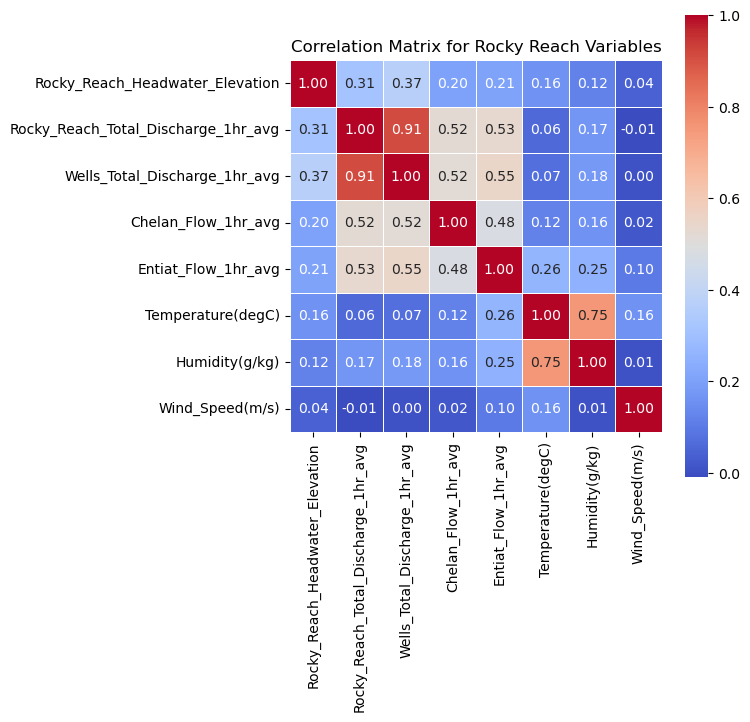

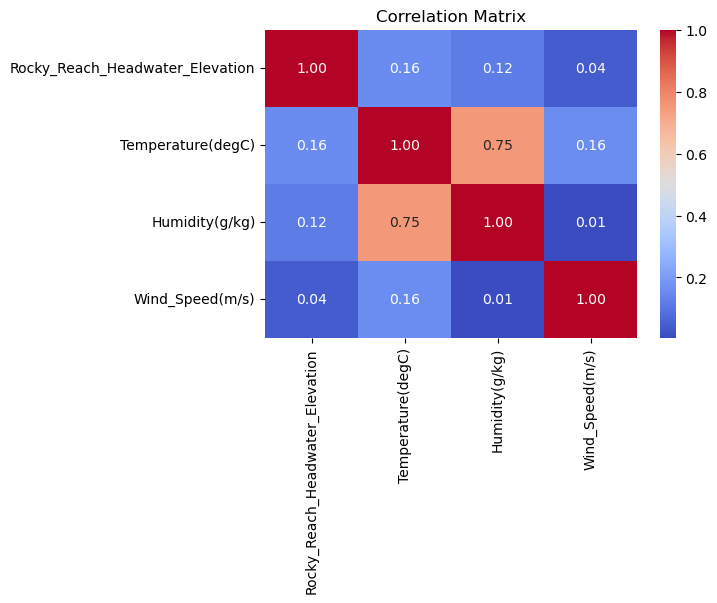

In [191]:
# Calculating the correlation matrix
corr_rocky_reach = data.corr()

# Setting up the matplotlib figure
plt.figure(figsize=(6, 6))
sns.heatmap(corr_rocky_reach, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)
plt.title('Correlation Matrix for Rocky Reach Variables')
plt.show()

# Compute correlation matrix
correlation_matrix = data[['Rocky_Reach_Headwater_Elevation', 'Temperature(degC)', 'Humidity(g/kg)', 'Wind_Speed(m/s)']].corr()

# Use seaborn to create a heatmap of the correlations
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

It appears there is some correlation between Headwater Elevation and Weather data

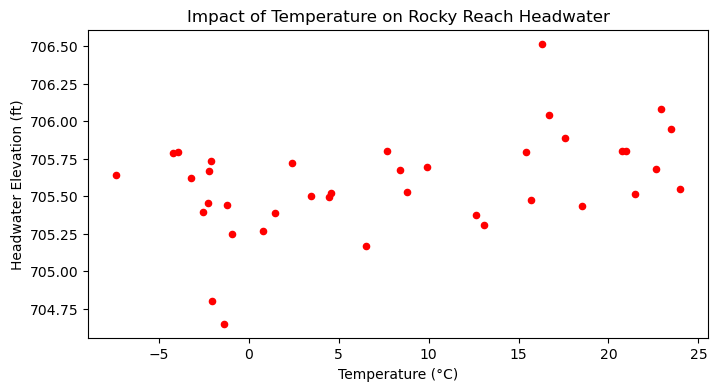

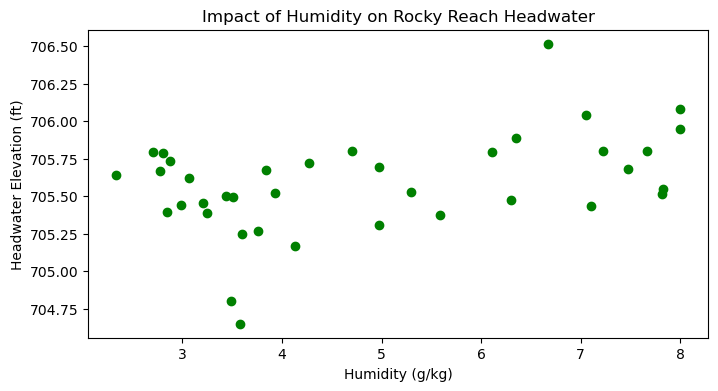

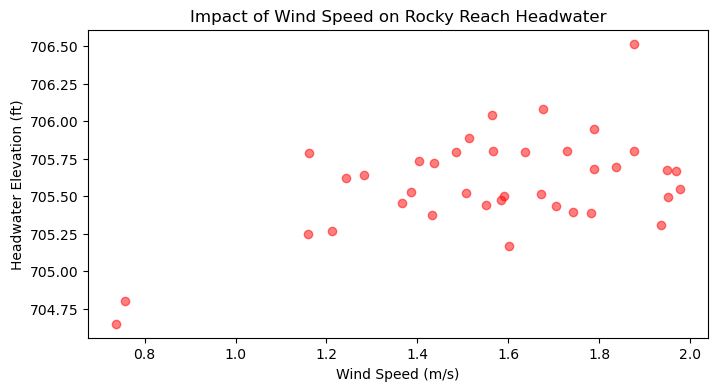

In [192]:
# Averaging for each month for plots
monthly_data = data.resample('M').mean()

# Scatter plot of Temperature vs. Headwater Elevation
plt.figure(figsize=(8, 4))
plt.scatter(monthly_data['Temperature(degC)'], monthly_data['Rocky_Reach_Headwater_Elevation'], color = 'red', s=20)
plt.title('Impact of Temperature on Rocky Reach Headwater')
plt.xlabel('Temperature (°C)')
plt.ylabel('Headwater Elevation (ft)')
plt.show()

# Scatter plot of Humidity vs. Headwater Elevation
plt.figure(figsize=(8, 4))
plt.scatter(monthly_data['Humidity(g/kg)'], monthly_data['Rocky_Reach_Headwater_Elevation'], color='green')
plt.title('Impact of Humidity on Rocky Reach Headwater')
plt.xlabel('Humidity (g/kg)')
plt.ylabel('Headwater Elevation (ft)')
plt.show()

# Scatter plot of Wind Speed vs. Headwater Elevation
plt.figure(figsize=(8, 4))
plt.scatter(monthly_data['Wind_Speed(m/s)'], monthly_data['Rocky_Reach_Headwater_Elevation'], alpha=0.5, color='red')
plt.title('Impact of Wind Speed on Rocky Reach Headwater')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Headwater Elevation (ft)')
plt.show()

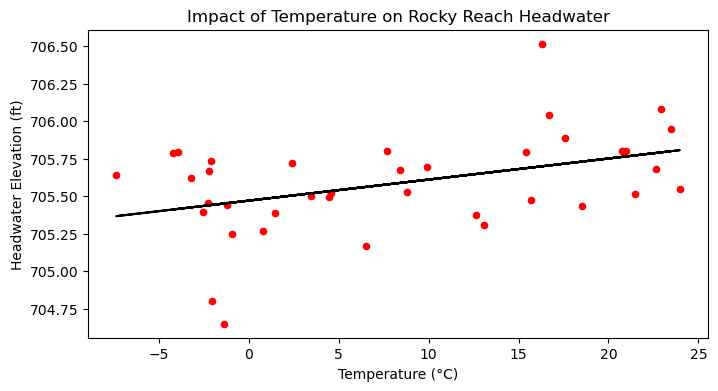

In [193]:
import numpy as np
import matplotlib.pyplot as plt

# Scatter plot of Temperature vs. Headwater Elevation
plt.figure(figsize=(8, 4))
plt.scatter(monthly_data['Temperature(degC)'], monthly_data['Rocky_Reach_Headwater_Elevation'], color='red', s=20)

# Calculate the linear regression line
slope, intercept = np.polyfit(monthly_data['Temperature(degC)'].dropna(), monthly_data['Rocky_Reach_Headwater_Elevation'].dropna(), 1)
plt.plot(monthly_data['Temperature(degC)'], slope * monthly_data['Temperature(degC)'] + intercept, color='black')

# Plot enhancements
plt.title('Impact of Temperature on Rocky Reach Headwater')
plt.xlabel('Temperature (°C)')
plt.ylabel('Headwater Elevation (ft)')
plt.show()

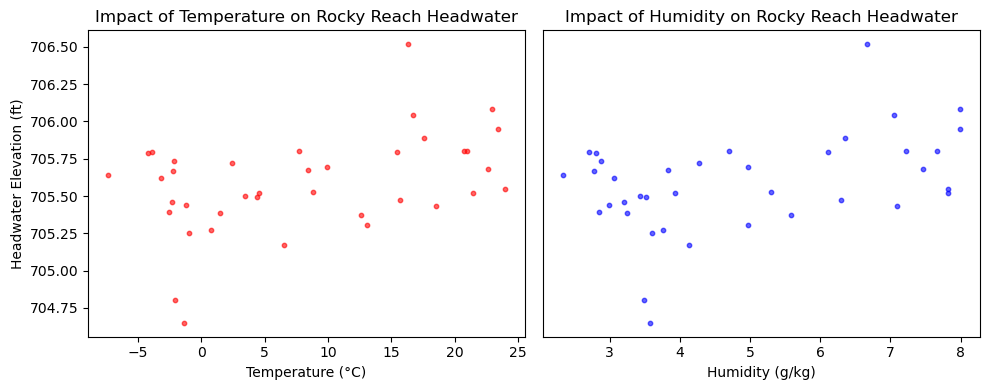

In [195]:
import matplotlib.pyplot as plt

# Plotting side by side using subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Scatter plot of Temperature vs. Headwater Elevation
axs[0].scatter(monthly_data['Temperature(degC)'], monthly_data['Rocky_Reach_Headwater_Elevation'], color='red', alpha=0.6, s=10)
axs[0].set_title('Impact of Temperature on Rocky Reach Headwater')
axs[0].set_xlabel('Temperature (°C)')
axs[0].set_ylabel('Headwater Elevation (ft)')

# Scatter plot of Humidity vs. Headwater Elevation
axs[1].scatter(monthly_data['Humidity(g/kg)'], monthly_data['Rocky_Reach_Headwater_Elevation'], color='blue', alpha=0.6, s=10)
axs[1].set_title('Impact of Humidity on Rocky Reach Headwater')
axs[1].set_xlabel('Humidity (g/kg)')
axs[1].set_yticks([])

plt.tight_layout()
plt.show()

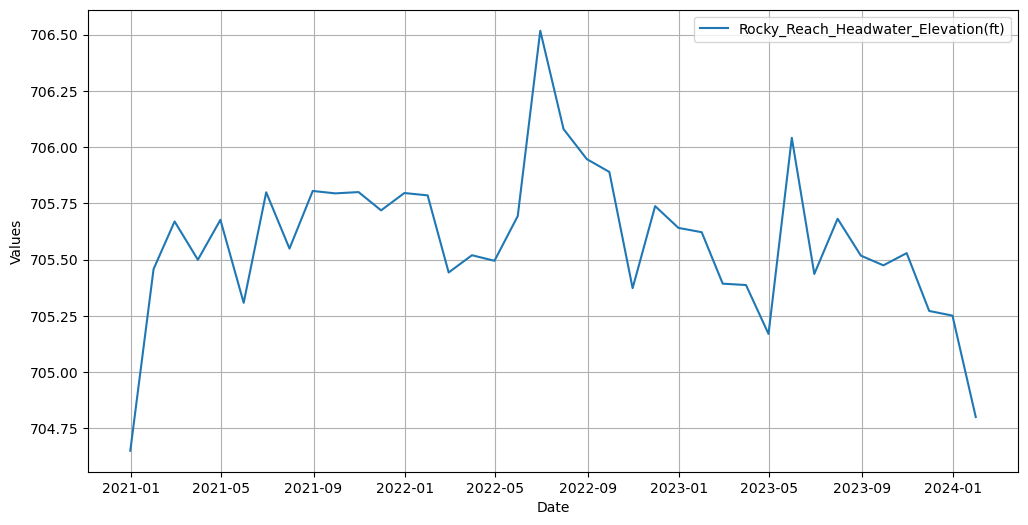

In [196]:
# Plotting Rocky Reach Headwater Elevation over time
plt.figure(figsize=(12, 6))
plt.plot(monthly_data.index, monthly_data['Rocky_Reach_Headwater_Elevation'], label='Rocky_Reach_Headwater_Elevation(ft)')
plt.xlabel('Date')
plt.ylabel('Values')
plt.grid(True)
plt.legend()
plt.show()

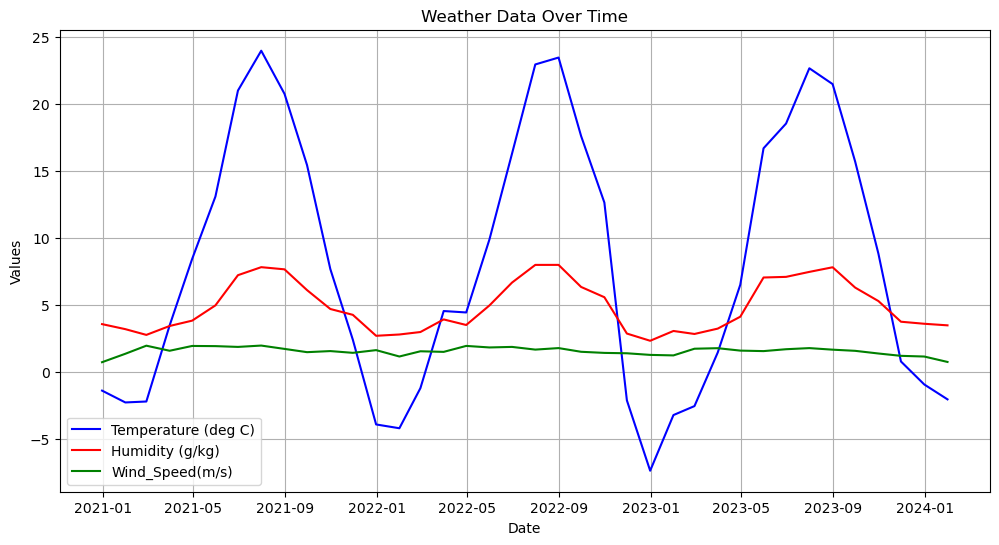

In [198]:
# Plotting Temperature and Humidity over time
plt.figure(figsize=(12, 6))
plt.plot(monthly_data.index, monthly_data['Temperature(degC)'], label='Temperature (deg C)', color='blue')
plt.plot(monthly_data.index, monthly_data['Humidity(g/kg)'], label='Humidity (g/kg)', color='red')
plt.plot(monthly_data.index, monthly_data['Wind_Speed(m/s)'], label='Wind_Speed(m/s)', color='green')
plt.title('Weather Data Over Time')
plt.xlabel('Date')
plt.ylabel('Values')
plt.grid(True)
plt.legend()
plt.show()

### 1.7.2. Feature Engineering, Feature Selection and Modeling

We will engineer additional features and use PCA for feature selection before building a regression model.

In [199]:
# Feature Engineering
# Adding lags for selected features
features_to_lag = ['Wells_Total_Discharge_1hr_avg', 'Chelan_Flow_1hr_avg', 'Entiat_Flow_1hr_avg']
lags = [1, 2]  # considering only two lags given hourly data

data['Wells_Total_Discharge_1hr_avg_lag1'] = data['Wells_Total_Discharge_1hr_avg'].shift(1)
data['Chelan_Flow_hr_avg_lag1'] = data['Chelan_Flow_1hr_avg'].shift(1)
data['Entiat_Flow_hr_avg_lag1'] = data['Chelan_Flow_1hr_avg'].shift(1)

# Dropping rows with missing values after lagging
data.dropna(inplace=True)

# Separate features and target
target = 'Rocky_Reach_Headwater_Elevation'
X = data.drop(columns=[target]) 
y = data[target]  # Target

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

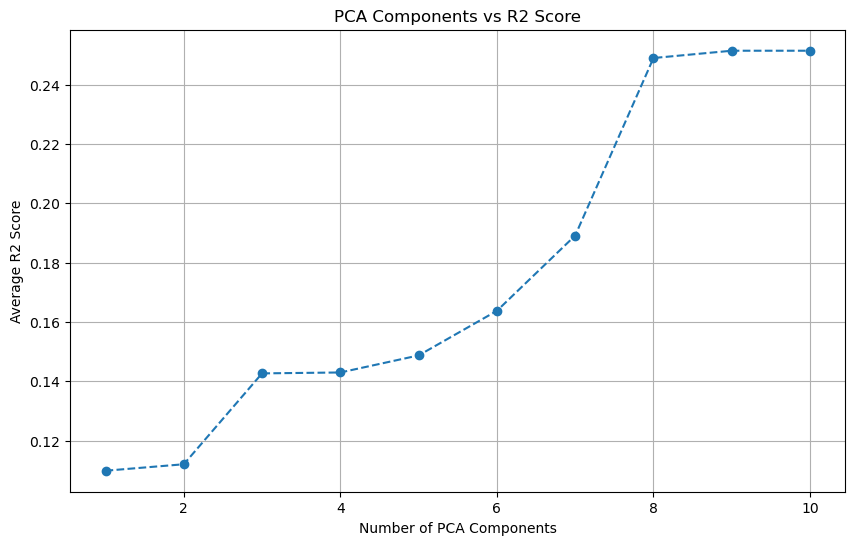

In [200]:
# Define a range of components to test
component_range = range(1, 11)

# Store the average cross-validation score for each number of components
cv_scores = []

# Set up cross-validation scheme
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search
for n_components in component_range:
    # Set up PCA with the current number of components
    pca = PCA(n_components=n_components)
    
    # Transform X accordingly
    X_pca = pca.fit_transform(X_scaled)
    
    # Set up the regression model
    model = LinearRegression()
    
    # Perform cross-validation and store the average score
    scores = cross_val_score(model, X_pca, y, cv=cv, scoring='r2')
    cv_scores.append(np.mean(scores))


# Plot the scores
plt.figure(figsize=(10, 6))
plt.plot(component_range, cv_scores, marker='o', linestyle='--')
plt.xlabel('Number of PCA Components')
plt.ylabel('Average R2 Score')
plt.title('PCA Components vs R2 Score')
plt.grid(True)
plt.show()

In [201]:
# Set up PCA with the optimal number of components
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, shuffle=False)

# Model training with Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print("Mean Squared Error for Rocky Reach Dam:", mean_squared_error(y_test, y_pred))
print("R-Squared for Rocky Reach Dam:", r2_score(y_test, y_pred))

Mean Squared Error for Rocky Reach Dam: 0.36212040384105604
R-Squared for Rocky Reach Dam: 0.1740847034037143


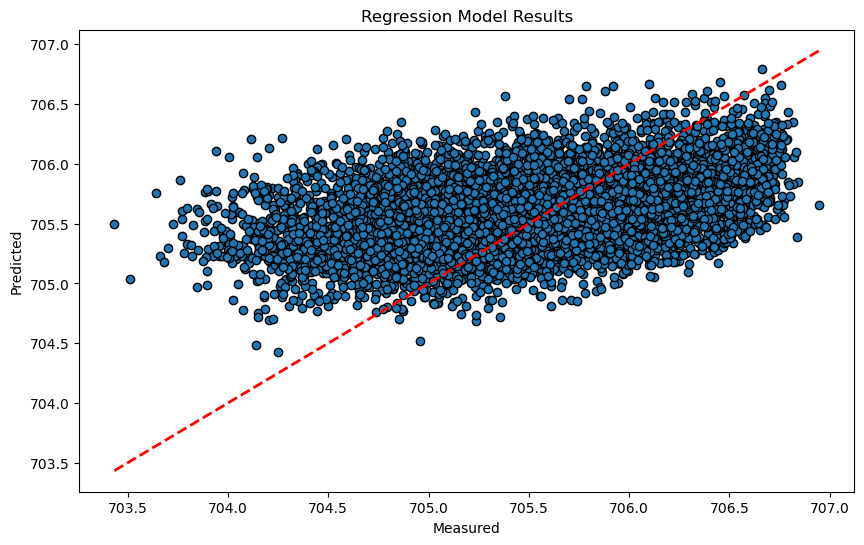

In [202]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Regression Model Results')
plt.show()

In [203]:
# Identifying the most influential features in PCA
# Components given by pca
components = pca.components_

# Function to get top features for each component
def get_top_features_for_component(component, num_features):
    sorted_feature_indices = np.argsort(np.abs(component))[::-1][:num_features]
    return X.columns[sorted_feature_indices]

# Getting top 10 features for each component
num_top_features = 10 
top_features_per_component = {}

for i, component in enumerate(components):
    top_features = get_top_features_for_component(component, num_top_features)
    top_features_per_component[f"Component {i+1}"] = top_features

# Counting how often each feature appears in the top lists
feature_counts = pd.Series(np.concatenate(list(top_features_per_component.values()))).value_counts()

# Displaying the most frequently appearing features
print("10 Most Influential Features in 15 Components PCA for Rocky Reach")
print(feature_counts.head(10))

10 Most Influential Features in 15 Components PCA for Rocky Reach
Entiat_Flow_hr_avg_lag1                10
Chelan_Flow_hr_avg_lag1                10
Chelan_Flow_1hr_avg                    10
Wells_Total_Discharge_1hr_avg          10
Wells_Total_Discharge_1hr_avg_lag1     10
Rocky_Reach_Total_Discharge_1hr_avg    10
Entiat_Flow_1hr_avg                    10
Humidity(g/kg)                         10
Temperature(degC)                      10
Wind_Speed(m/s)                        10
Name: count, dtype: int64


## 1.8. Pricing Data Integration

In this section, we will integrate pricing data and analyze its impact on Rocky Reach total discharge.

In [75]:
df_rocky_reach = df.copy()

columns_to_drop = ['datetime_stamp', 'Wenatchee_Flow', 'Rock_Island_Total_Discharge', 'Rock_Island_Headwater_Elevation']

# Drop the unnecessary columns
df_rocky_reach = df_rocky_reach.drop(columns=columns_to_drop).copy()

In [76]:
# Load and preprocess pricing data
pricing_data = pd.read_csv('caiso_pricing.csv')

# Drop unnecessary columns
columns_to_drop = ['Unnamed: 0','datetime']
pricing_data = pricing_data.drop(columns=columns_to_drop).copy()
pricing_data.head()

datetime_utc     value
0  2022-05-03 07:00:00  72.28085
1  2022-05-03 07:05:00  61.95501
2  2022-05-03 07:10:00  61.95501
3  2022-05-03 07:15:00  72.16517
4  2022-05-03 07:20:00  51.54655

In [77]:
# Convert 'datetime_utc' to datetime format if not already done
df_rocky_reach['datetime_utc'] = pd.to_datetime(df_rocky_reach['datetime_utc'])

# Check minimum and maximum dates in the dataset
rocky_reach_start_date = df_rocky_reach['datetime_utc'].min()
rocky_reach_end_date = df_rocky_reach['datetime_utc'].max()

# Display the start and end dates
print("Rocky Reach Dataset Start Date:", rocky_reach_start_date)
print("Rocky Reach Dataset End Date:", rocky_reach_end_date)

Rocky Reach Dataset Start Date: 2019-01-01 08:00:00+00:00
Rocky Reach Dataset End Date: 2024-01-01 07:59:00+00:00


In [78]:
# Convert 'datetime_utc' to datetime format if not already done
pricing_data['datetime_utc'] = pd.to_datetime(pricing_data['datetime_utc'])

# Check minimum and maximum dates in the dataset
pricing_data_start_date = pricing_data['datetime_utc'].min()
pricing_data_end_date = pricing_data['datetime_utc'].max()

# Display the start and end dates
print("Pricing Dataset Start Date:", pricing_data_start_date)
print("Pricing Dataset End Date:", pricing_data_end_date)

Pricing Dataset Start Date: 2022-05-03 07:00:00
Pricing Dataset End Date: 2024-01-01 07:55:00


In [79]:
# Set the datetime index for both datasets
df_rocky_reach.set_index('datetime_utc', inplace=True)
pricing_data.set_index('datetime_utc', inplace=True)

# Remove timezone information from df_rocky_reach if it's timezone-aware
if df_rocky_reach.index.tz is not None:
    df_rocky_reach.index = df_rocky_reach.index.tz_localize(None)

# Similarly, ensure pricing_data is also timezone-naive
if pricing_data.index.tz is not None:
    pricing_data.index = pricing_data.index.tz_localize(None)

# Merge the datasets on their index (datetime)
data = pd.merge(df_rocky_reach, pricing_data, left_index=True, right_index=True, how='inner')
print("Combined Data Shape:", data.shape)
print("Combined Dataset Start Date:", data.index.min())
print("Combined Dataset End Date:", data.index.max())

Combined Data Shape: (173964, 6)
Combined Dataset Start Date: 2022-05-03 07:00:00
Combined Dataset End Date: 2024-01-01 07:55:00


### 1.8.1. Checking Relationship between Pricing Data and Rocky Reach

We will analyze the correlation between pricing data and Rocky Reach headwater elevation and discharge.

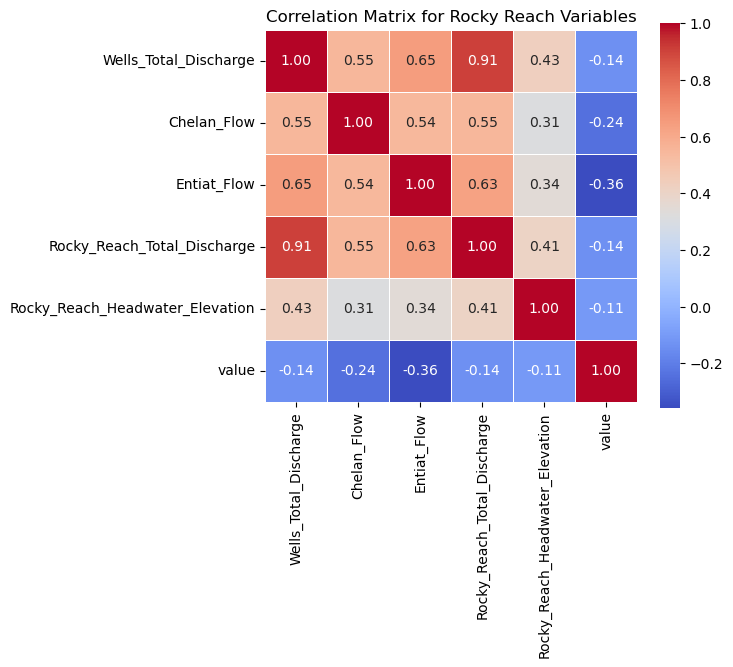

In [80]:
# Calculating the correlation matrix
corr_rocky_reach = data.corr()

# Setting up the matplotlib figure
plt.figure(figsize=(6, 5))
sns.heatmap(corr_rocky_reach, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)
plt.title('Correlation Matrix for Rocky Reach Variables')
plt.show()

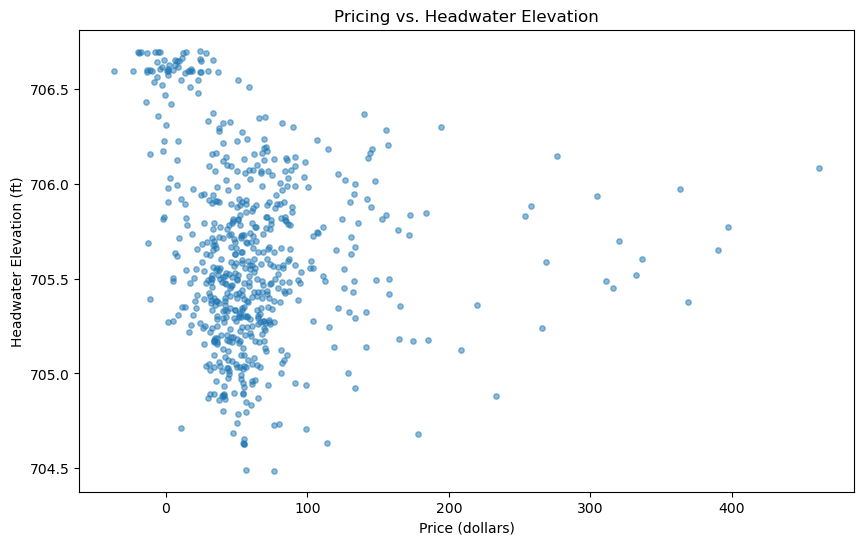

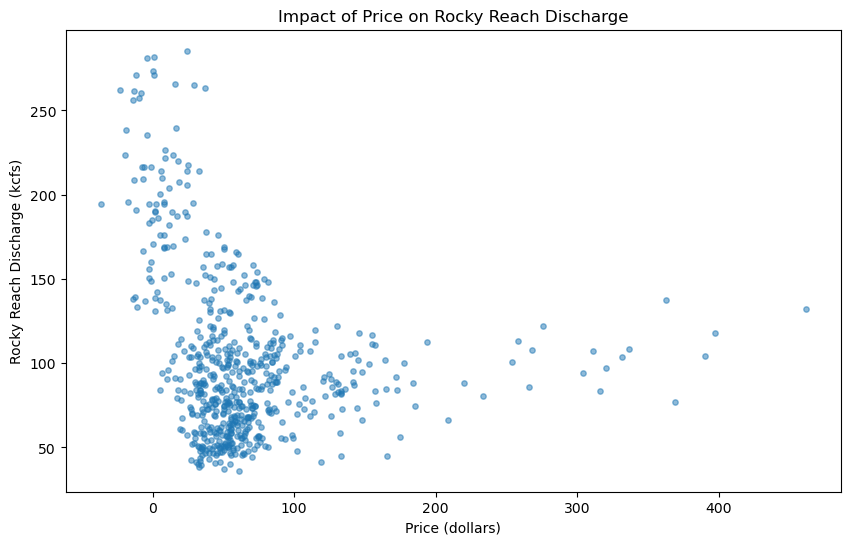

In [81]:
# Scatter plot of Pricing vs. Headwater Elevation
daily_data = data.resample('D').mean()

plt.figure(figsize=(10, 6))
plt.scatter(daily_data['value'], daily_data['Rocky_Reach_Headwater_Elevation'], s=15, alpha=0.5)
plt.title('Pricing vs. Headwater Elevation')
plt.xlabel('Price (dollars)')
plt.ylabel('Headwater Elevation (ft)')
plt.show()

# Scatter plot of Pricing vs. Rocky Reach Discharge
plt.figure(figsize=(10, 6))
plt.scatter(daily_data['value'], daily_data['Rocky_Reach_Total_Discharge'], s=15, alpha=0.5)
plt.title('Impact of Price on Rocky Reach Discharge')
plt.xlabel('Price (dollars)')
plt.ylabel('Rocky Reach Discharge (kcfs)')
plt.show()

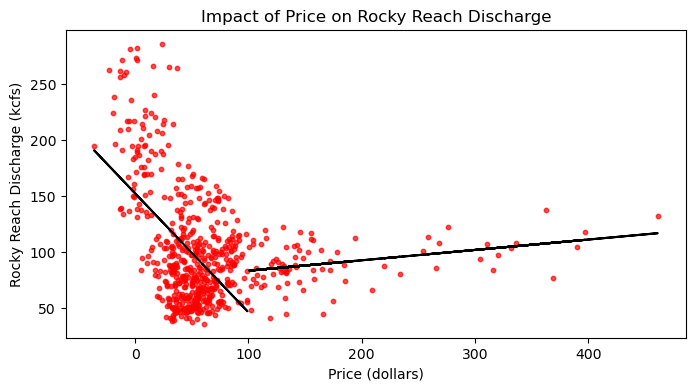

In [82]:
# Scatter plots with Linear Regression Lines for Pricing Data
subset1 = daily_data[daily_data['value'] <= 100]
subset2 = daily_data[daily_data['value'] > 100]

plt.figure(figsize=(8, 4))
plt.scatter(subset1['value'], subset1['Rocky_Reach_Total_Discharge'], s=10, alpha=0.7, color='red')
plt.scatter(subset2['value'], subset2['Rocky_Reach_Total_Discharge'], s=10, alpha=0.7, color='red')

# Calculate the linear regression line for the first subset
slope1, intercept1 = np.polyfit(subset1['value'].dropna(), subset1['Rocky_Reach_Total_Discharge'].dropna(), 1)
plt.plot(subset1['value'], slope1 * subset1['value'] + intercept1, color='black', label='Trend 1')

# Calculate the linear regression line for the second subset
slope2, intercept2 = np.polyfit(subset2['value'].dropna(), subset2['Rocky_Reach_Total_Discharge'].dropna(), 1)
plt.plot(subset2['value'], slope2 * subset2['value'] + intercept2, color='black', label='Trend 2')

plt.title('Impact of Price on Rocky Reach Discharge')
plt.xlabel('Price (dollars)')
plt.ylabel('Rocky Reach Discharge (kcfs)')
plt.show()

#### 5-min data

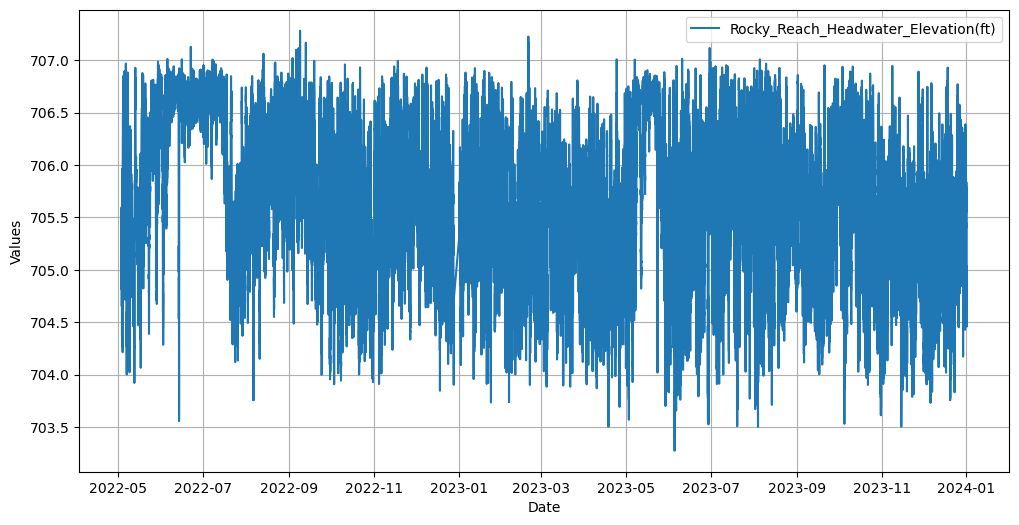

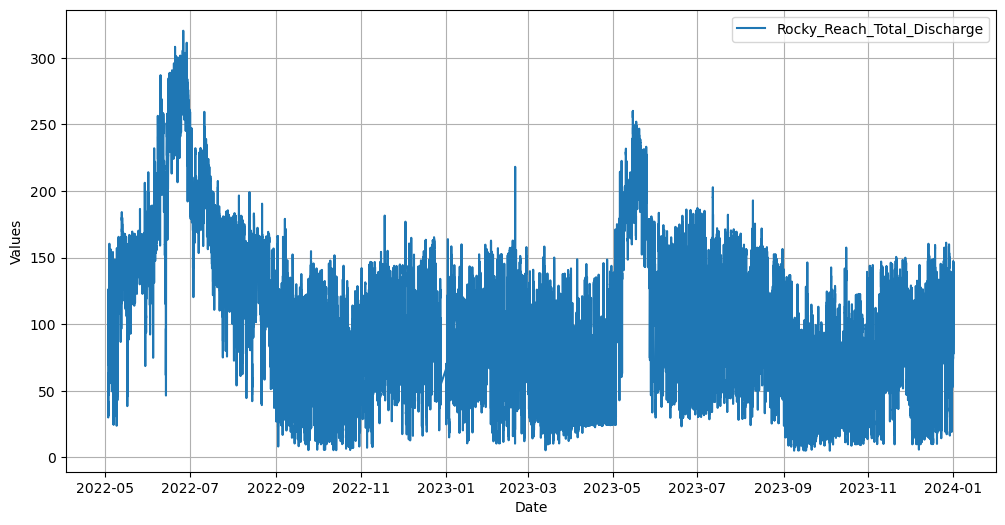

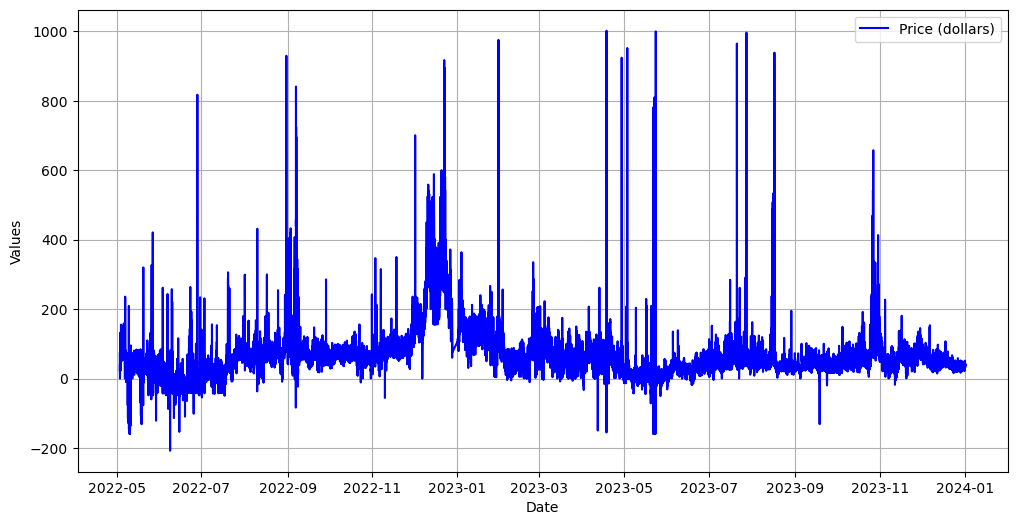

In [83]:
# Plotting Pricing, Rocky Reach Headwater Elevation, and Discharge over time
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Rocky_Reach_Headwater_Elevation'], label='Rocky_Reach_Headwater_Elevation(ft)')
plt.xlabel('Date')
plt.ylabel('Values')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Rocky_Reach_Total_Discharge'], label='Rocky_Reach_Total_Discharge')
plt.xlabel('Date')
plt.ylabel('Values')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['value'], label='Price (dollars)', color='blue')
plt.xlabel('Date')
plt.ylabel('Values')
plt.grid(True)
plt.legend()
plt.show()

#### Daily Data

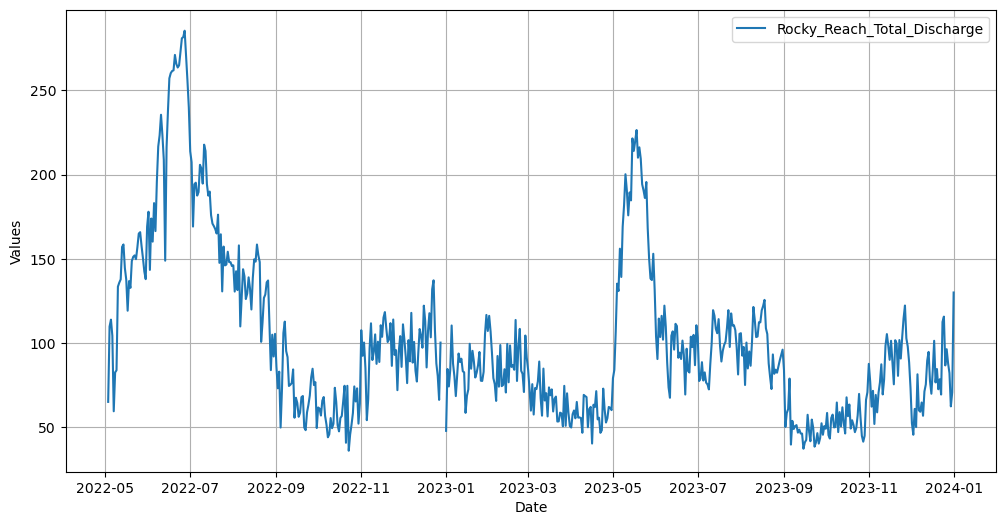

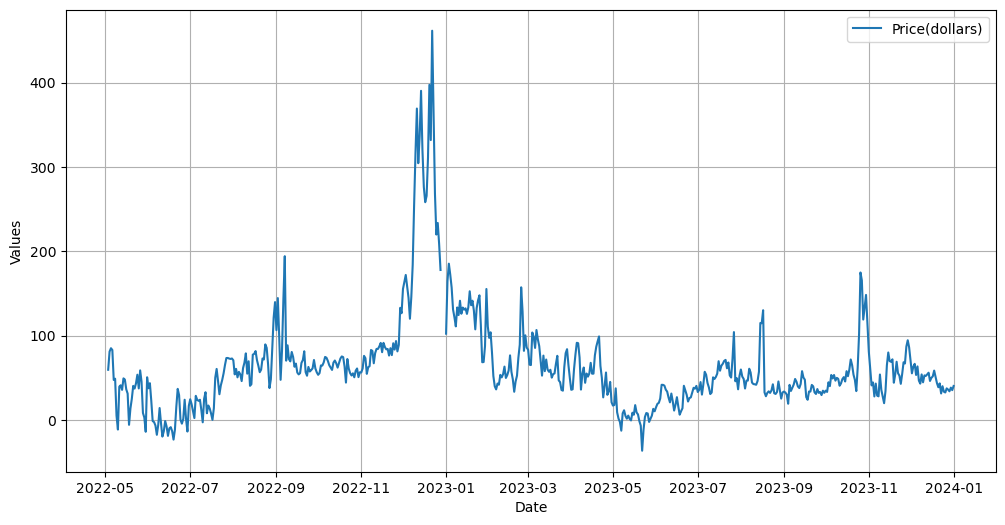

In [84]:
# Resample the data to daily averages
daily_data = data.resample('D').mean()

plt.figure(figsize=(12, 6))
plt.plot(daily_data.index, daily_data['Rocky_Reach_Total_Discharge'], label='Rocky_Reach_Total_Discharge')
plt.xlabel('Date')
plt.ylabel('Values')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(daily_data.index, daily_data['value'], label='Price(dollars)')
plt.xlabel('Date')
plt.ylabel('Values')
plt.grid(True)
plt.legend()
plt.show()

### 1.8.2. Feature Engineering, Feature Selection and Modeling

We will engineer additional features from the pricing data and use PCA for feature selection before building a regression model.

In [85]:
# Create time-based features
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['month'] = data.index.month

# Rolling window features (example for a 20-minute window)
data['price_rolling_mean_20'] = data['value'].rolling(window=4).mean()  # since data is in 5-minute intervals
data['discharge_rolling_mean_20'] = data['Rocky_Reach_Total_Discharge'].rolling(window=4).mean()

# Lagged pricing features
for lag in range(1, 5):  # lag up to 20 minutes
    data[f'price_lag_{lag}'] = data['value'].shift(lag)

# Fill missing values
data.bfill(inplace=True)
data.ffill(inplace=True)

In [87]:
# Separate features and target
X = data.drop(['Rocky_Reach_Total_Discharge'], axis=1)
y = data['Rocky_Reach_Total_Discharge']  # You can change this to fill rate

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Optimal Components = 10

In [88]:
# Set up PCA with the optimal number of components
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, shuffle=False)

# Model training with Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-Squared:", r2_score(y_test, y_pred))

Mean Squared Error: 23.260659551812378
R-Squared: 0.9840895312689664


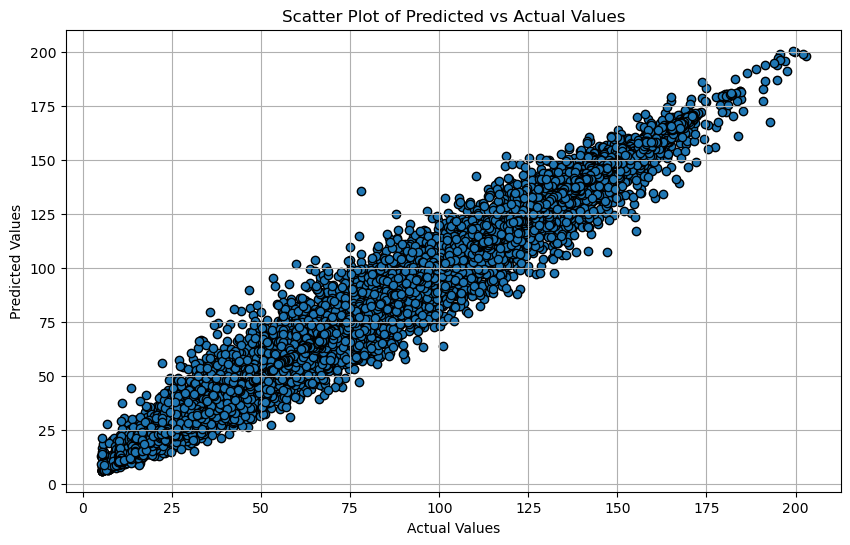

In [89]:
# Scatter plot of predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, edgecolors='k')
plt.title('Scatter Plot of Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

In [90]:
# Identifying the most influential features in PCA
components = pca.components_

# Function to get top features for each component
def get_top_features_for_component(component, num_features):
    sorted_feature_indices = np.argsort(np.abs(component))[::-1][:num_features]
    return X.columns[sorted_feature_indices]

# Getting top 10 features for each component
num_top_features = 10 
top_features_per_component = {}

for i, component in enumerate(components):
    top_features = get_top_features_for_component(component, num_top_features)
    top_features_per_component[f"Component {i+1}"] = top_features

# Counting how often each feature appears in the top lists
feature_counts = pd.Series(np.concatenate(list(top_features_per_component.values()))).value_counts()

# Displaying the most frequently appearing features
print("Most Influential Features in PCA:")
print(feature_counts.head(10))

Most Influential Features in PCA:
Entiat_Flow                        10
price_lag_1                         8
Chelan_Flow                         8
discharge_rolling_mean_20           8
Rocky_Reach_Headwater_Elevation     8
price_rolling_mean_20               7
price_lag_2                         7
price_lag_3                         7
value                               7
Wells_Total_Discharge               7
Name: count, dtype: int64


# 2. Rock Island
## 2.1. Traditional Model for Headwater Elevation Changes based on Fill Rate
### 2.1.1. Rock Island Inflow Calculation
We will calculate the Rock Island Inflow based on the flow impacts from upstream sources. The impacts are calculated using moving averages and shifted data.

Rocky Reach Flow Impact = Depends on Rocky Reach Total Discharge (RRTD) at time (now) 

Wenatchee Flow Impact = flow from 22 minutes ago

Rocky Reach Flow Timing Logic:

If RRTD <= 50, then Rocky Reach Flow Impact = RRTD from 43 min ago

If RRTD > 50 & RRTD <= 80, then Rocky Reach Flow Impact = RRTD from 45 min ago

If RRTD > 80 & RRTD <= 120, then Rocky Reach Flow Impact = RRTD from 47 min ago

If RRTD > 120 & RRTD <= 150, then Rocky Reach Flow Impact = RRTD from 48 min ago

If RRTD > 150 & RRTD <= 220, then Rocky Reach Flow Impact = RRTD from 50 min ago

If RRTD > 220, then Rocky Reach Flow Impact = RRTD from 50 min ago

Rock Island Inflow = Rocky Reach Flow Impact + Wenatchee Flow Impact

In [92]:
df_rock_island = df.copy()

# Define the conditions and corresponding shifts
conditions = [50, 80, 120, 150, 220]
shifts = [43, 45, 47, 48, 50]

# Calculate 'Rocky_Reach_Flow_Impact' in a vectorized way
df_rock_island['Rocky_Reach_Flow_Impact'] = np.select(
    [df_rock_island['Rocky_Reach_Total_Discharge'] <= condition for condition in conditions],
    [df_rock_island['Rocky_Reach_Total_Discharge'].shift(shift) for shift in shifts],
    default=df_rock_island['Rocky_Reach_Total_Discharge'].shift(50)
)
# For starting rows
df_rock_island['Rocky_Reach_Flow_Impact'].bfill(inplace = True)

# Calculate 'Wenatchee_Flow_Impact' with backward filling
df_rock_island['Wenatchee_Flow_Impact'] = df_rock_island['Wenatchee_Flow'].shift(22)
df_rock_island['Wenatchee_Flow_Impact'].bfill(inplace = True)

df_rock_island['Rock_Island_Inflow'] = df_rock_island['Rocky_Reach_Flow_Impact'] + df_rock_island['Wenatchee_Flow_Impact']

df_rock_island.head()

datetime_utc      datetime_stamp  Wells_Total_Discharge  \
0 2019-01-01 08:00:00+00:00 2019-01-01 08:00:00              64.991571   
1 2019-01-01 08:01:00+00:00 2019-01-01 08:01:00              59.312555   
2 2019-01-01 08:02:00+00:00 2019-01-01 08:02:00              51.471802   
3 2019-01-01 08:03:00+00:00 2019-01-01 08:03:00              54.252264   
4 2019-01-01 08:04:00+00:00 2019-01-01 08:04:00              55.120167   

   Chelan_Flow  Entiat_Flow  Rocky_Reach_Total_Discharge  Wenatchee_Flow  \
0     2.387225          0.0                    72.286020        1.823813   
1     2.387256          0.0                    68.821629        1.823704   
2     2.387287          0.0                    66.502634        1.823594   
3     2.387319          0.0                    63.876623        1.823484   
4     2.387350          0.0                    62.371067        1.823375   

   Rock_Island_Total_Discharge  Rock_Island_Headwater_Elevation  \
0                    95.571837                       612.805419   
1                    95.675746                       612.793892   
2                    94.028171                       612.812751   
3                    93.075551                       612.836556   
4                    93.617712                       612.834370   

   Rocky_Reach_Headwater_Elevation  Rocky_Reach_Flow_Impact  \
0                       705.512061                 72.28602   
1                       705.510341                 72.28602   
2                       705.515385                 72.28602   
3                       705.546697                 72.28602   
4                       705.581749                 72.28602   

   Wenatchee_Flow_Impact  Rock_Island_Inflow  
0               1.823813           74.109834  
1               1.823813           74.109834  
2               1.823813           74.109834  
3               1.823813           74.109834  
4               1.823813           74.109834

### 2.1.2. Calculate Rock Island Fill Rate
The fill rate is calculated as the difference between the Rock Island inflow and the total discharge.

In [93]:
df_rock_island['Rock_Island_Fill_Rate'] = df_rock_island['Rock_Island_Inflow'] - df_rock_island['Rock_Island_Total_Discharge']

# Display the updated DataFrame
df_rock_island[['Rock_Island_Fill_Rate']].head()

Rock_Island_Fill_Rate
0             -21.462003
1             -21.565912
2             -19.918337
3             -18.965717
4             -19.507878

### 2.1.3. Correlation Analysis
We will analyze the correlation between the Rock Island Fill Rate and the changes in headwater elevation.

In [94]:
# Calculate the change in Rock Island headwater elevation
df_rock_island['Rock_Island_Headwater_Elevation_Change'] = df_rock_island['Rocky_Reach_Headwater_Elevation'].diff()
df_rock_island['Rock_Island_Headwater_Elevation_Change'].fillna(method='ffill', inplace=True)
df_rock_island['Rock_Island_Headwater_Elevation_Change'].fillna(method='bfill', inplace=True)

# Calculate the correlation between Rock Island Fill Rate and Headwater Elevation Change
rock_island_correlation = df_rock_island['Rock_Island_Fill_Rate'].corr(df_rock_island['Rock_Island_Headwater_Elevation_Change'])
print(f'Correlation between Rock Island Fill Rate and Headwater Elevation Change: {rock_island_correlation}')

Correlation between Rock Island Fill Rate and Headwater Elevation Change: 0.02491092562140496


In [95]:
# Prepare data for modeling for Rock Island Dam
X_rock_island = df_rock_island[['Rock_Island_Fill_Rate']]
y_rock_island = df_rock_island['Rock_Island_Headwater_Elevation_Change']

# Split the data into training and testing sets
X_train_rock_island, X_test_rock_island, y_train_rock_island, y_test_rock_island = train_test_split(
    X_rock_island, y_rock_island, test_size=0.3, shuffle=False
)

# Create a linear regression model for Rock Island Dam
model_rock_island = LinearRegression()

# Train the model for Rock Island Dam
model_rock_island.fit(X_train_rock_island, y_train_rock_island)

# Make predictions on the test set for Rock Island Dam
y_pred_rock_island = model_rock_island.predict(X_test_rock_island)

# Evaluate the model for Rock Island Dam
mse_rock_island = mean_squared_error(y_test_rock_island, y_pred_rock_island)
r2_rock_island = r2_score(y_test_rock_island, y_pred_rock_island)

print(f'Mean Squared Error for Rock Island Dam: {mse_rock_island}')
print(f'R-squared for Rock Island Dam: {r2_rock_island}')

Mean Squared Error for Rock Island Dam: 0.001387549517038528
R-squared for Rock Island Dam: 0.0011975351343800344


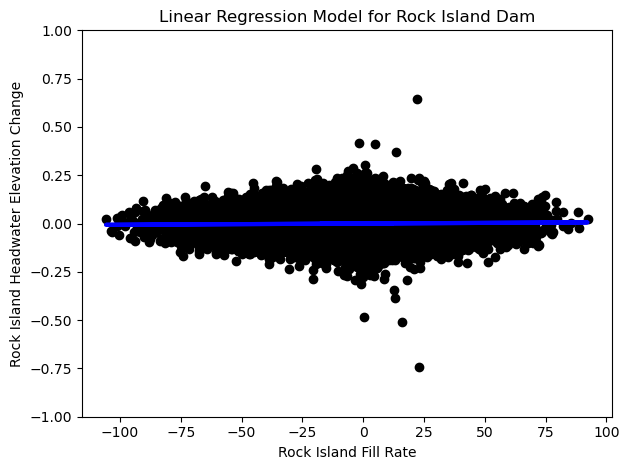

In [96]:
# Plot the regression line for Rock Island Dam
plt.scatter(X_test_rock_island, y_test_rock_island, color='black')
plt.plot(X_test_rock_island, y_pred_rock_island, color='blue', linewidth=3)
plt.title('Linear Regression Model for Rock Island Dam')
plt.xlabel('Rock Island Fill Rate')
plt.ylabel('Rock Island Headwater Elevation Change')

plt.ylim(-1, 1)

plt.tight_layout()
plt.show()

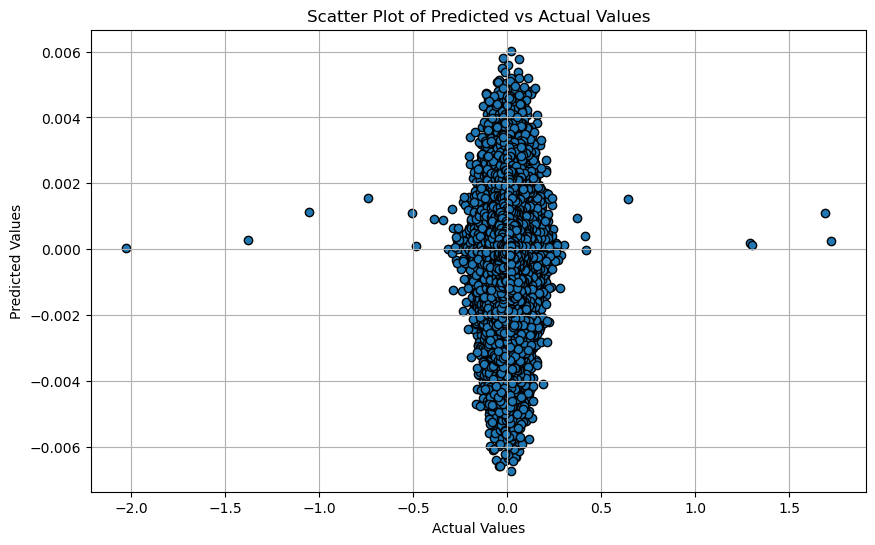

In [97]:
# Scatter plot of predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_rock_island, y_pred_rock_island, edgecolors='k')
plt.title('Scatter Plot of Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

## 2.2. Traditional Model for Headwater Elevation based on Fill Rate
We will build another linear regression model to predict the headwater elevation based on the fill rate.

In [98]:
# Calculate the correlation between Rock Island Fill Rate and Headwater Elevation Change
rock_island_correlation = df_rock_island['Rock_Island_Fill_Rate'].corr(df_rock_island['Rock_Island_Headwater_Elevation'])
print(f'Correlation between Rock Island Fill Rate and Headwater Elevation: {rock_island_correlation}')

Correlation between Rock Island Fill Rate and Headwater Elevation: 0.14430899694970623


In [99]:
# Prepare data for modeling for Rock Island Dam
X_rock_island = df_rock_island[['Rock_Island_Fill_Rate']]
y_rock_island = df_rock_island['Rock_Island_Headwater_Elevation']

# Split the data into training and testing sets
X_train_rock_island, X_test_rock_island, y_train_rock_island, y_test_rock_island = train_test_split(
    X_rock_island, y_rock_island, test_size=0.3, shuffle=False
)

# Create a linear regression model for Rock Island Dam
model_rock_island = LinearRegression()

# Train the model for Rock Island Dam
model_rock_island.fit(X_train_rock_island, y_train_rock_island)

# Make predictions on the test set for Rock Island Dam
y_pred_rock_island = model_rock_island.predict(X_test_rock_island)

# Evaluate the model for Rock Island Dam
mse_rock_island = mean_squared_error(y_test_rock_island, y_pred_rock_island)
r2_rock_island = r2_score(y_test_rock_island, y_pred_rock_island)

print(f'Mean Squared Error for Rock Island Dam: {mse_rock_island}')
print(f'R-squared for Rock Island Dam: {r2_rock_island}')

Mean Squared Error for Rock Island Dam: 0.2607801922849963
R-squared for Rock Island Dam: -0.19345994481979156


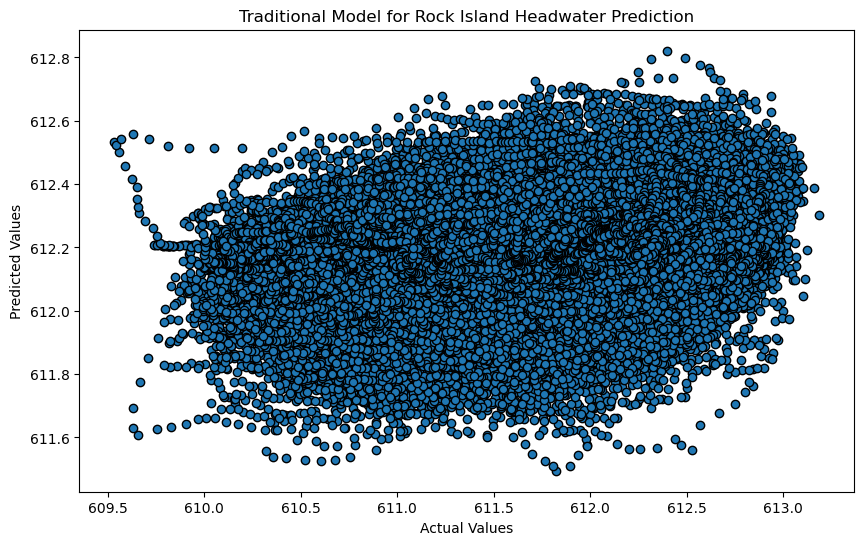

In [100]:
# Scatter plot of predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_rock_island, y_pred_rock_island, edgecolors='k')
plt.title('Traditional Model for Rock Island Headwater Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

## 2.3. Traditional Method for Headwater Elevation Based on Upstream Flow Impact

We will build a model using the impacts from upstream flows to predict headwater elevation.

In [102]:
# Prepare data for modeling for Rock Island Dam
X_rock_island = df_rock_island[['Rocky_Reach_Flow_Impact', 'Wenatchee_Flow_Impact']]
y_rock_island = df_rock_island['Rock_Island_Headwater_Elevation']

# Split the data into training and testing sets
X_train_rock_island, X_test_rock_island, y_train_rock_island, y_test_rock_island = train_test_split(
    X_rock_island, y_rock_island, test_size=0.3,shuffle=False
)

# Create a linear regression model for Rock Island Dam
model_rock_island = LinearRegression()

# Train the model for Rock Island Dam
model_rock_island.fit(X_train_rock_island, y_train_rock_island)

# Make predictions on the test set for Rock Island Dam
y_pred_rock_island = model_rock_island.predict(X_test_rock_island)

# Evaluate the model for Rock Island Dam
mse_rock_island = mean_squared_error(y_test_rock_island, y_pred_rock_island)
r2_rock_island = r2_score(y_test_rock_island, y_pred_rock_island)

print(f'Mean Squared Error for Rock Island Dam: {mse_rock_island}')
print(f'R-squared for Rock Island Dam: {r2_rock_island}')

Mean Squared Error for Rock Island Dam: 0.26417224186058935
R-squared for Rock Island Dam: -0.20898365183082523


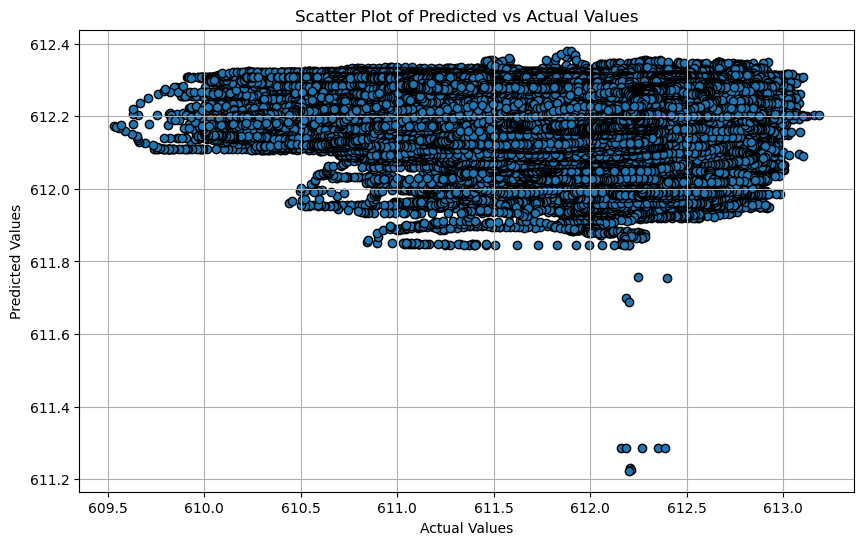

In [103]:
# Scatter plot of predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_rock_island, y_pred_rock_island, edgecolors='k')
plt.title('Scatter Plot of Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

## 2.4. Headwater Elevation based on Feature Engineering and Feature Selection Using PCA

We will engineer additional features, apply PCA for dimensionality reduction, and build a regression model.

### 2.4.1 Feature Engineering

In [104]:
df_rock_island = df.copy()

# Rock Island Headwater Elevation lag for last 2 minutes
for lag in range(1, 3):
    df_rock_island[f'Rock_Island_Headwater_Elevation_lag_{lag}'] = df_rock_island['Rock_Island_Headwater_Elevation'].shift(lag)

# Rocky Island Discharge lag for last 2 minutes
for lag in range(1, 3):
    df_rock_island[f'Rock_Island_Total_Discharge_lag_{lag}'] = df_rock_island['Rock_Island_Total_Discharge'].shift(lag)

# Wells Flow Impact = flows from last 15-30 minutes.
for lag in range(15, 31):
    df_rock_island[f'Wenatchee_Flow_lag_{lag}'] = df_rock_island['Wenatchee_Flow'].shift(lag)

# Rocky Reach Discharge Impact = Discharge lags from last 60 to 90 minutes
for lag in range(60, 91):
    df_rock_island[f'Rocky_Reach_Total_Discharge_lag_{lag}'] = df_rock_island['Rocky_Reach_Total_Discharge'].shift(lag)
    

# List of columns to drop
columns_to_drop = ['datetime_utc','datetime_stamp', 'Wells_Total_Discharge', 'Rock_Island_Total_Discharge',
                   'Chelan_Flow', 'Entiat_Flow', 'Rocky_Reach_Total_Discharge',
                   'Wenatchee_Flow', 'Rocky_Reach_Headwater_Elevation']

df_rock_island = df_rock_island.drop(columns=columns_to_drop).copy()

# Drop rows with missing values
df_rock_island.dropna(inplace=True)
df_rock_island.shape

(2629350, 52)

### 2.4.2. Feature Selection Using PCA and Modeling

We will use PCA to reduce the dimensionality of the data and then build a regression model.

In [105]:
# Separate features and target
target = 'Rock_Island_Headwater_Elevation'
X = df_rock_island.drop(columns=[target]) 
y = df_rock_island[target]  # Target

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Running above code will give following result

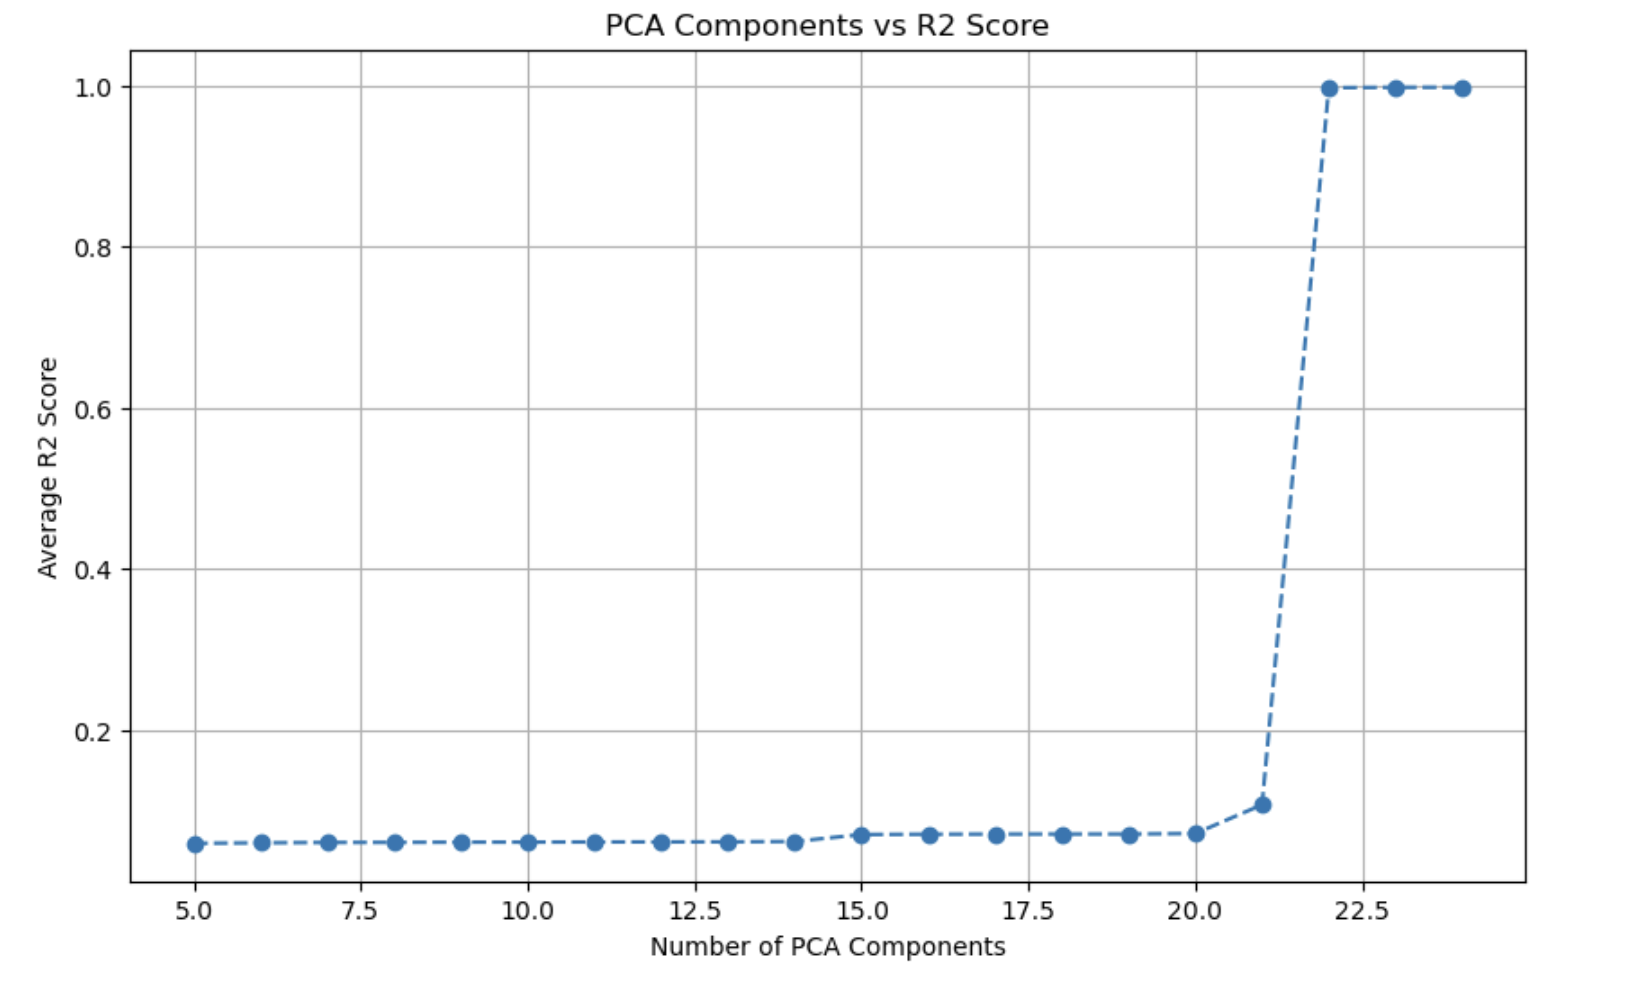

Optimal components = 22

In [112]:
# Set up PCA with the optimal number of components
pca = PCA(n_components=22)
X_pca = pca.fit_transform(X)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, shuffle=False)

# Model training with Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print("Mean Squared Error for Rock Island Dam:", mean_squared_error(y_test, y_pred))
print("R-Squared for Rock Island Dam:", r2_score(y_test, y_pred))

Mean Squared Error for Rock Island Dam: 0.000750850284583835
R-Squared for Rock Island Dam: 0.9965635878924053


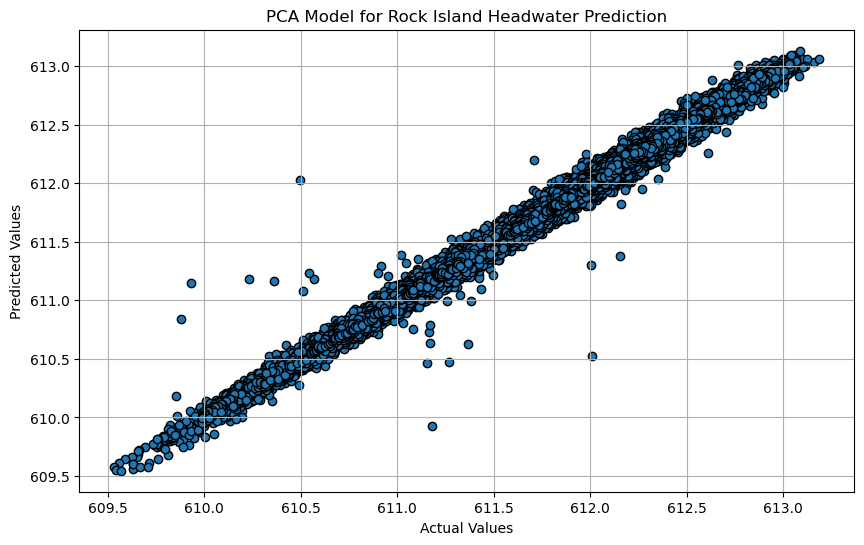

In [113]:
# Scatter plot of predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, edgecolors='k')
plt.title('PCA Model for Rock Island Headwater Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

### 2.4.3. Comparison of Traditional and PCA Models
We will compare the traditional model and PCA model predictions.

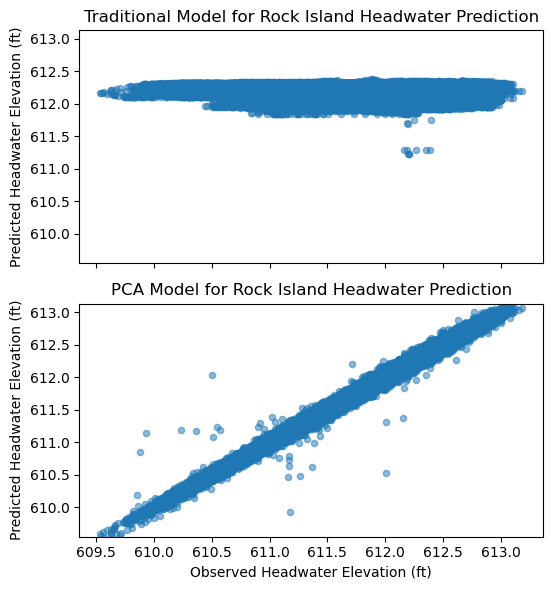

In [114]:
# Create a figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5.5, 6))

# Traditional Model
ax1.scatter(y_test_rock_island, y_pred_rock_island, s=20, alpha=0.5)
ax1.set_title('Traditional Model for Rock Island Headwater Prediction')
ax1.set_ylabel('Predicted Headwater Elevation (ft)')

# PCA Model
ax2.scatter(y_test, y_pred, s=20, alpha=0.5)
ax2.set_title('PCA Model for Rock Island Headwater Prediction')
ax2.set_xlabel('Observed Headwater Elevation (ft)')  # Shared x-axis label
ax2.set_ylabel('Predicted Headwater Elevation (ft)')

# Determine consistent y-limits
all_predicted_values = list(y_pred_rock_island) + list(y_pred)  # Combine predicted values
y_min = min(all_predicted_values)  # Find minimum
y_max = max(all_predicted_values)  # Find maximum

# Apply consistent y-limits to both subplots
ax1.set_ylim([y_min, y_max])
ax2.set_ylim([y_min, y_max])

# Remove extra x-axis label and tick labels from the first subplot
ax1.tick_params(labelbottom=False)

# Tight layout to adjust spacing
plt.tight_layout()

plt.show()

### 2.4.4. Most Influential Features in PCA
We will identify the most influential features in the PCA components.

In [115]:
# Components given by pca
components = pca.components_

# Function to get top features for each component
def get_top_features_for_component(component, num_features):
    sorted_feature_indices = np.argsort(np.abs(component))[::-1][:num_features]
    return X.columns[sorted_feature_indices]

# Getting top 10 features for each component
num_top_features = 10 
top_features_per_component = {}

for i, component in enumerate(components):
    top_features = get_top_features_for_component(component, num_top_features)
    top_features_per_component[f"Component {i+1}"] = top_features

# Counting how often each feature appears in the top lists
feature_counts = pd.Series(np.concatenate(list(top_features_per_component.values()))).value_counts()

# Displaying the most frequently appearing features
print("Most Influential Features in PCA:")
print(feature_counts.head(10))

Most Influential Features in PCA:
Rocky_Reach_Total_Discharge_lag_90    11
Rocky_Reach_Total_Discharge_lag_60    11
Rocky_Reach_Total_Discharge_lag_71     9
Rocky_Reach_Total_Discharge_lag_75     9
Rocky_Reach_Total_Discharge_lag_74     8
Rocky_Reach_Total_Discharge_lag_76     8
Rocky_Reach_Total_Discharge_lag_85     8
Rocky_Reach_Total_Discharge_lag_67     8
Rocky_Reach_Total_Discharge_lag_70     7
Rocky_Reach_Total_Discharge_lag_79     6
Name: count, dtype: int64


### 2.4.6. Final Model Coefficients
We will map the final contributions of the original features in the PCA-based regression model.

In [116]:
pca_components = pca.components_
regression_coefficients = model.coef_
intercept = model.intercept_

# Calculate contributions of original features
n_features = X.shape[1]
feature_contributions = np.zeros(n_features)
for i in range(pca.n_components_):
    feature_contributions += pca.components_[i, :] * regression_coefficients[i]

# Adjust for original feature scaling
feature_contributions *= scaler.scale_

# Final contributions including the intercept
final_contributions = np.concatenate(([intercept], feature_contributions))

# Mapping contributions back to feature names
feature_names = ['Intercept'] + list(X.columns)
final_model_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': final_contributions})
final_model_df

Feature  Coefficient
0                               Intercept   612.129200
1   Rock_Island_Headwater_Elevation_lag_1     0.266813
2   Rock_Island_Headwater_Elevation_lag_2     0.266686
3       Rock_Island_Total_Discharge_lag_1    -0.490756
4       Rock_Island_Total_Discharge_lag_2     0.469395
5                   Wenatchee_Flow_lag_15     0.001518
6                   Wenatchee_Flow_lag_16     0.001640
7                   Wenatchee_Flow_lag_17     0.001481
8                   Wenatchee_Flow_lag_18     0.001155
9                   Wenatchee_Flow_lag_19     0.000703
10                  Wenatchee_Flow_lag_20     0.000227
11                  Wenatchee_Flow_lag_21    -0.000184
12                  Wenatchee_Flow_lag_22    -0.000515
13                  Wenatchee_Flow_lag_23    -0.000698
14                  Wenatchee_Flow_lag_24    -0.000770
15                  Wenatchee_Flow_lag_25    -0.000769
16                  Wenatchee_Flow_lag_26    -0.000709
17                  Wenatchee_Flow_lag_27    -0.000621
18                  Wenatchee_Flow_lag_28    -0.000514
19                  Wenatchee_Flow_lag_29    -0.000450
20                  Wenatchee_Flow_lag_30    -0.000519
21     Rocky_Reach_Total_Discharge_lag_60     0.280810
22     Rocky_Reach_Total_Discharge_lag_61    -0.395225
23     Rocky_Reach_Total_Discharge_lag_62     0.043598
24     Rocky_Reach_Total_Discharge_lag_63     0.265197
25     Rocky_Reach_Total_Discharge_lag_64    -0.153171
26     Rocky_Reach_Total_Discharge_lag_65    -0.143881
27     Rocky_Reach_Total_Discharge_lag_66     0.220274
28     Rocky_Reach_Total_Discharge_lag_67     0.006634
29     Rocky_Reach_Total_Discharge_lag_68    -0.209530
30     Rocky_Reach_Total_Discharge_lag_69     0.068797
31     Rocky_Reach_Total_Discharge_lag_70     0.145867
32     Rocky_Reach_Total_Discharge_lag_71    -0.130150
33     Rocky_Reach_Total_Discharge_lag_72    -0.090515
34     Rocky_Reach_Total_Discharge_lag_73     0.195310
35     Rocky_Reach_Total_Discharge_lag_74     0.003694
36     Rocky_Reach_Total_Discharge_lag_75    -0.190334
37     Rocky_Reach_Total_Discharge_lag_76     0.073120
38     Rocky_Reach_Total_Discharge_lag_77     0.118830
39     Rocky_Reach_Total_Discharge_lag_78    -0.116058
40     Rocky_Reach_Total_Discharge_lag_79    -0.071773
41     Rocky_Reach_Total_Discharge_lag_80     0.160646
42     Rocky_Reach_Total_Discharge_lag_81     0.006671
43     Rocky_Reach_Total_Discharge_lag_82    -0.150063
44     Rocky_Reach_Total_Discharge_lag_83     0.053592
45     Rocky_Reach_Total_Discharge_lag_84     0.140140
46     Rocky_Reach_Total_Discharge_lag_85    -0.149223
47     Rocky_Reach_Total_Discharge_lag_86    -0.055040
48     Rocky_Reach_Total_Discharge_lag_87     0.175704
49     Rocky_Reach_Total_Discharge_lag_88     0.010820
50     Rocky_Reach_Total_Discharge_lag_89    -0.229300
51     Rocky_Reach_Total_Discharge_lag_90     0.134933

## 2.5. Feature Engineering and PCA by Seperating 2023's data to check for Overfitting

### 2.5.1. Feature Engineering

In [117]:
df_rock_island = df.copy()

# Rock Island Headwater Elevation lag for last 2 minutes
for lag in range(1, 3):
    df_rock_island[f'Rock_Island_Headwater_Elevation_lag_{lag}'] = df_rock_island['Rock_Island_Headwater_Elevation'].shift(lag)

# Rocky Island Discharge lag for last 2 minutes
for lag in range(1, 3):
    df_rock_island[f'Rock_Island_Total_Discharge_lag_{lag}'] = df_rock_island['Rock_Island_Total_Discharge'].shift(lag)

# Wells Flow Impact = flows from last 15-30 minutes.
for lag in range(15, 31):
    df_rock_island[f'Wenatchee_Flow_lag_{lag}'] = df_rock_island['Wenatchee_Flow'].shift(lag)

# Rocky Reach Discharge Impact = Discharge lags from last 60 to 90 minutes
for lag in range(60, 91):
    df_rock_island[f'Rocky_Reach_Total_Discharge_lag_{lag}'] = df_rock_island['Rocky_Reach_Total_Discharge'].shift(lag)

# List of columns to drop
columns_to_drop = ['datetime_stamp', 'Wells_Total_Discharge', 'Rock_Island_Total_Discharge',
                   'Chelan_Flow', 'Entiat_Flow', 'Rocky_Reach_Total_Discharge',
                   'Wenatchee_Flow', 'Rocky_Reach_Headwater_Elevation']

df_rock_island = df_rock_island.drop(columns=columns_to_drop).copy()

# Drop rows with missing values
df_rock_island.dropna(inplace=True)

# Create a new dataframe with the filtered data for years before 2023
df_rock_island_before_2023 = df_rock_island[df_rock_island['datetime_utc'].dt.year < 2023]

# Create a new dataframe with 2023 data 
df_rock_island_2023 = df_rock_island[df_rock_island['datetime_utc'].dt.year == 2023]


df_rock_island_before_2023 = df_rock_island_before_2023.drop(columns=['datetime_utc']).copy()
df_rock_island_2023 = df_rock_island_2023.drop(columns=['datetime_utc']).copy()

# Check the results
print(df_rock_island_before_2023.shape)
print(df_rock_island_2023.shape)

(2103270, 52)
(525600, 52)


### 2.5.2. Feature Seelection Using PCA and Modeling

In [118]:
# Separate features and target
target = 'Rock_Island_Headwater_Elevation'
X = df_rock_island_before_2023.drop(columns=[target]) 
y = df_rock_island_before_2023[target]  # Target

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Optimal Components is 22

In [119]:
# Set up PCA with the optimal number of components
pca = PCA(n_components = 22)
X_pca = pca.fit_transform(X)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, shuffle=False)

# Model training with Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print("Mean Squared Error for Rock Island Dam:", mean_squared_error(y_test, y_pred))
print("R-Squared for Rock Island Dam:", r2_score(y_test, y_pred))

Mean Squared Error for Rock Island Dam: 0.0008613558842299027
R-Squared for Rock Island Dam: 0.994793682196462


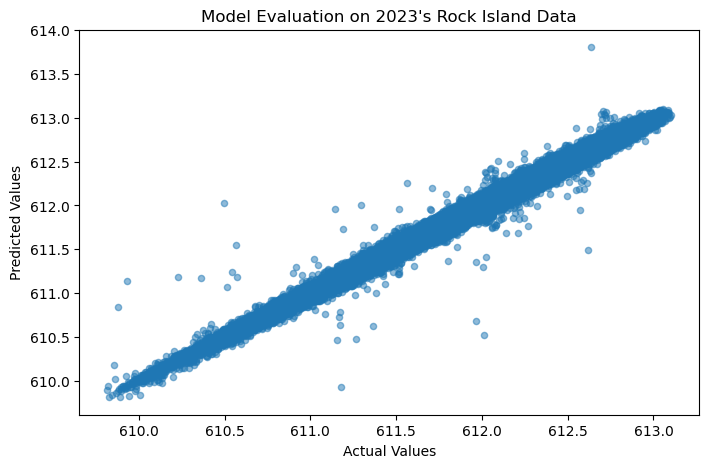

In [120]:
# Creating a scatter plot of y_pred vs y_eval
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, s=20, alpha=0.5)
plt.title("Model Evaluation on 2023's Rock Island Data")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

### 2.5.3 Model Evaluation on 2023's data

In [122]:
df_rock_island_2023.shape

(525600, 52)

In [123]:
target = 'Rock_Island_Headwater_Elevation'
X_eval = df_rock_island_2023.drop(columns=[target]) 
y_eval = df_rock_island_2023[target]  # Target

X_eval_pca_corrected = pca.transform(X_eval)

y_pred = model.predict(X_eval_pca_corrected)
print("Mean Squared Error for Rock Island Dam:", mean_squared_error(y_eval, y_pred))
print("R-Squared for Rock Island Dam:", r2_score(y_eval, y_pred))

Mean Squared Error for Rock Island Dam: 0.0008185626774614473
R-Squared for Rock Island Dam: 0.996390618945413


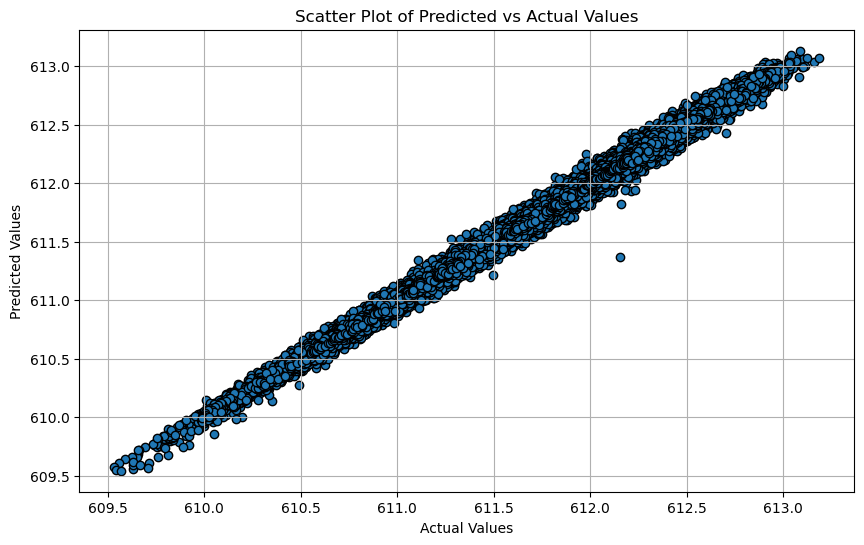

In [124]:
# Creating a scatter plot of y_pred vs y_eval
plt.figure(figsize=(10, 6))
plt.scatter(y_eval, y_pred, edgecolors='k')
plt.title('Scatter Plot of Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()


## 2.6. Time Series Model for Forecasting Headwater Elevation
We will build a time series model to forecast the headwater elevation for January 2023 based on previous data.

In [127]:
df_rock_island = df.copy()
df_rock_island.set_index('datetime_utc', inplace=True)

# Filter data up to 2022 and for 2023
train_data = df_rock_island[df_rock_island.index.year < 2023]
test_data = df_rock_island[(df_rock_island.index.year == 2023)]

# Focusing on relevant features
features = ['Rocky_Reach_Total_Discharge', 'Wenatchee_Flow', 'Rock_Island_Headwater_Elevation', 'Rock_Island_Total_Discharge']
train_data = train_data[features]
test_data = test_data[features]

train_data.shape, test_data.shape

((2103360, 4), (525600, 4))

### 2.6.1 Checking for Stationarity Using ADF Test

In [128]:
# Calculate the number of samples for 1% of the data
sample_size = int(len(train_data) * 0.01)

# Select the last 1% of the data as a subset
subset_data = train_data[-sample_size:]

# Confirm the size of the subset
print(subset_data.shape)

(21033, 4)


In [129]:
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, perform an Augmented Dickey Fuller test
    and report the results.
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')  # Drop na values and calculate the diff
    
    labels = ['ADF test statistic', 'p-value', '# lags used', '# observations']
    out = pd.Series(result[0:4], index=labels)

    for key, value in result[4].items():
        out[f'critical value ({key})'] = value

    print(out.to_string())  # This prints out the full ADF report
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

# Apply the ADF test on the subset
adf_test(subset_data['Rock_Island_Headwater_Elevation'], 'Rock Island Headwater Elevation Subset')

Augmented Dickey-Fuller Test: Rock Island Headwater Elevation Subset
ADF test statistic     -1.002562e+01
p-value                 1.635060e-17
# lags used             4.600000e+01
# observations          2.098600e+04
critical value (1%)    -3.430662e+00
critical value (5%)    -2.861678e+00
critical value (10%)   -2.566843e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Data is stationary. So, we can use time series models

### 2.6.2. Modeling and Forecasting Using VAR Model

In [143]:
# Model Building
model = VAR(train_data)
fitted_model = model.fit(maxlags= 60, ic= 'aic')  # 'aic' might be used for automatic lag selection

/Users/likhithaveganti/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)


In [144]:
# Forecasting
forecast_steps = len(test_data)
forecast = pd.DataFrame(
    fitted_model.forecast(
        train_data.values[-fitted_model.k_ar:], 
        steps=forecast_steps), 
    index=test_data.index, 
    columns=test_data.columns)

In [145]:
actual = test_data['Rock_Island_Headwater_Elevation']
predicted = forecast['Rock_Island_Headwater_Elevation']

# Compute MSE and R-squared
mse = mean_squared_error(actual, predicted)
r2 = r2_score(actual, predicted)

print("Mean Squared Error for Rock Island Dam:", mse)
print("R-Squared for Rock Island Dam:", r2)

Mean Squared Error for Rock Island Dam: 0.28817429006933826
R-Squared for Rock Island Dam: -0.2706795113368985


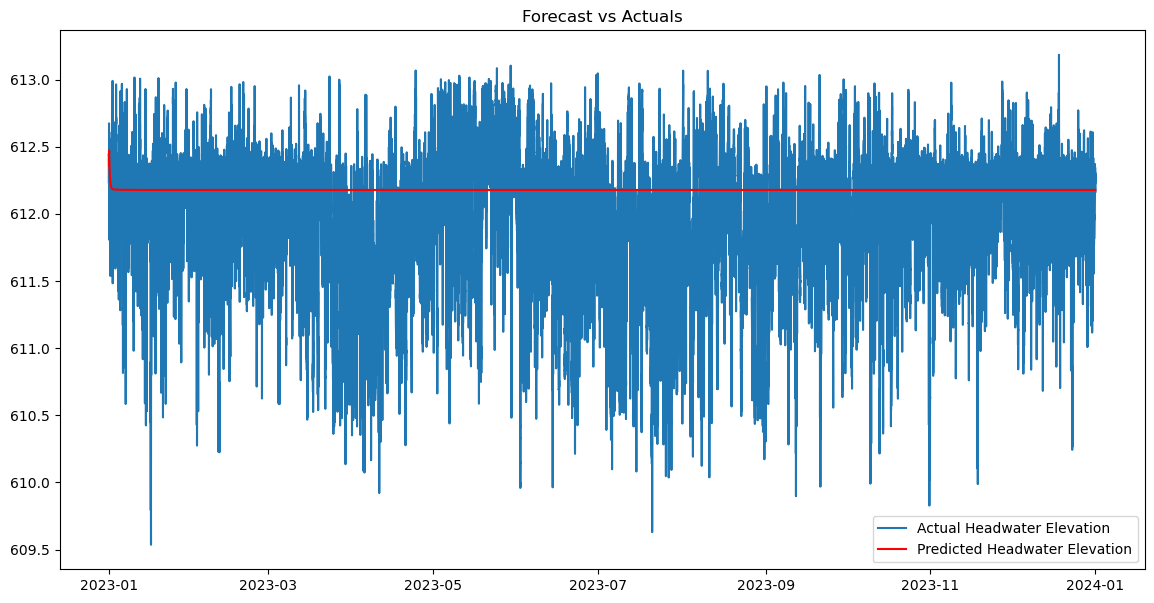

In [146]:
# Visualization
plt.figure(figsize=(14, 7))
plt.plot(test_data['Rock_Island_Headwater_Elevation'], label='Actual Headwater Elevation')
plt.plot(forecast['Rock_Island_Headwater_Elevation'], label='Predicted Headwater Elevation', color='red')
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()

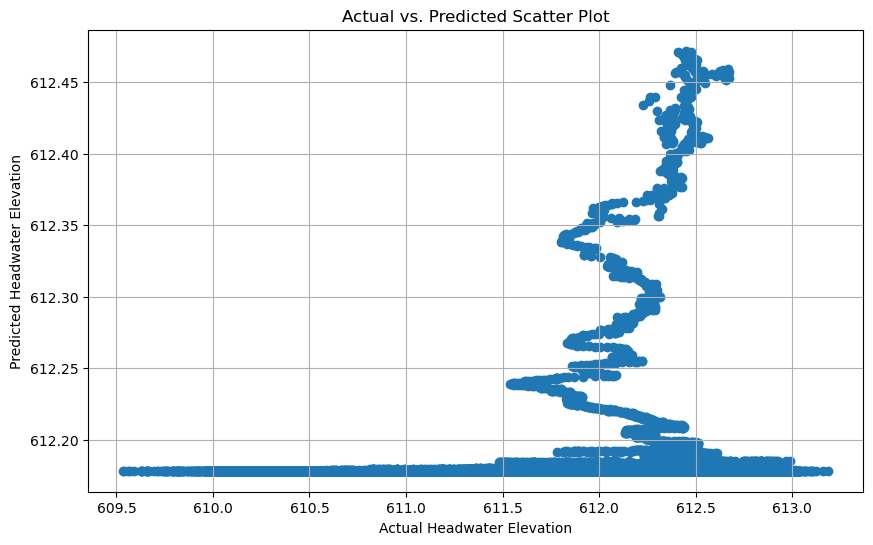

In [147]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(test_data['Rock_Island_Headwater_Elevation'], forecast['Rock_Island_Headwater_Elevation'])
plt.xlabel('Actual Headwater Elevation')
plt.ylabel('Predicted Headwater Elevation')
plt.title('Actual vs. Predicted Scatter Plot')
plt.grid(True)
plt.show()

## 2.7. Weather Data Integration

### 2.7.1. Data Preparation and Merging

We will integrate weather data into our model to improve the predictions.

In [130]:
df_rock_island = df.copy()

columns_to_drop = columns_to_drop = ['datetime_stamp', 'Wells_Total_Discharge',
                   'Chelan_Flow', 'Entiat_Flow', 'Rocky_Reach_Headwater_Elevation']

# Drop the unnecessary columns
df_rock_island = df_rock_island.drop(columns=columns_to_drop).copy()

In [131]:
weather_data = pd.read_csv('weather.csv')

# Parse the 'full_date' column as datetime
weather_data['datetime'] = pd.to_datetime(weather_data['full_date'], format='%m/%d/%y %H:%M')

# Drop unnecessary columns that are redundant or not needed for further analysis
columns_to_drop = ['YEAR', 'MO', 'DY', 'date', 'full_date', 'HR']
weather_data.drop(columns=columns_to_drop, inplace=True)

# Check the prepared DataFrame
weather_data.columns

Index(['Temperature(degC)', 'Humidity(g/kg)', 'Wind_Speed(m/s)', 'datetime'], dtype='object')

In [132]:
# Convert 'datetime_utc' to datetime format if not already done
df_rock_island['datetime_utc'] = pd.to_datetime(df_rock_island['datetime_utc'])

# Check minimum and maximum dates in the dataset
rock_island_start_date = df_rock_island['datetime_utc'].min()
rock_island_end_date = df_rock_island['datetime_utc'].max()

# Display the start and end dates
print("Rock Island Dataset Start Date:", rock_island_start_date)
print("Rock Island Dataset End Date:", rock_island_end_date)

Rock Island Dataset Start Date: 2019-01-01 08:00:00+00:00
Rock Island Dataset End Date: 2024-01-01 07:59:00+00:00


In [133]:
# Check minimum and maximum dates in the dataset
weather_data_start_date = weather_data['datetime'].min()
weather_data_end_date = weather_data['datetime'].max()

# Display the start and end dates
print("Weather Dataset Start Date:", weather_data_start_date)
print("Weather Dataset End Date:", weather_data_end_date)

Weather Dataset Start Date: 2020-12-31 16:00:00
Weather Dataset End Date: 2024-04-18 15:00:00


In [134]:
# Set the datetime index for both datasets
df_rock_island.set_index('datetime_utc', inplace=True)
weather_data.set_index('datetime', inplace=True)

# Remove timezone information from df_rock_island if it's timezone-aware
if df_rock_island.index.tz is not None:
    df_rock_island.index = df_rock_island.index.tz_localize(None)

# Similarly, ensure weather_data is also timezone-naive
if weather_data.index.tz is not None:
    weather_data.index = weather_data.index.tz_localize(None)

# Calculate rolling averages for the past 1 hour
rolling_columns = ['Rocky_Reach_Total_Discharge', 'Rock_Island_Total_Discharge', 'Wenatchee_Flow']
for column in rolling_columns:
    df_rock_island[f'{column}_1hr_avg'] = df_rock_island[column].rolling(window='1H', min_periods=1).mean()

# Drop original columns to keep only the averages if that's desired
df_rock_island.drop(columns=rolling_columns, inplace=True)

# Ensure both dataframes are resampled to hourly data, this aligns both time series on the hour
df_rock_island = df_rock_island.resample('H').mean()
weather_data = weather_data.resample('H').mean()

# Merge the datasets on their index (datetime)
data = pd.merge(df_rock_island, weather_data, left_index=True, right_index=True, how='inner')
data.head()

Rock_Island_Headwater_Elevation  \
2020-12-31 16:00:00                       612.140779   
2020-12-31 17:00:00                       612.022214   
2020-12-31 18:00:00                       612.079251   
2020-12-31 19:00:00                       612.035269   
2020-12-31 20:00:00                       612.089933   

                     Rocky_Reach_Total_Discharge_1hr_avg  \
2020-12-31 16:00:00                            76.922772   
2020-12-31 17:00:00                            71.214329   
2020-12-31 18:00:00                            66.731343   
2020-12-31 19:00:00                            68.235094   
2020-12-31 20:00:00                            68.075052   

                     Rock_Island_Total_Discharge_1hr_avg  \
2020-12-31 16:00:00                            83.127623   
2020-12-31 17:00:00                            82.056905   
2020-12-31 18:00:00                            71.079182   
2020-12-31 19:00:00                            69.887826   
2020-12-31 20:00:00                            72.215781   

                     Wenatchee_Flow_1hr_avg  Temperature(degC)  \
2020-12-31 16:00:00                1.993175              -0.15   
2020-12-31 17:00:00                1.993025              -1.29   
2020-12-31 18:00:00                1.992876              -1.76   
2020-12-31 19:00:00                1.992726              -1.95   
2020-12-31 20:00:00                1.992577              -2.01   

                     Humidity(g/kg)  Wind_Speed(m/s)  
2020-12-31 16:00:00            3.72             0.78  
2020-12-31 17:00:00            3.54             0.92  
2020-12-31 18:00:00            3.48             0.93  
2020-12-31 19:00:00            3.48             0.90  
2020-12-31 20:00:00            3.48             0.80

In [135]:
print("Combined Data Shape:", data.shape)
# Additional checks for alignment and data integrity
print("Combined Dataset Start Date:", data.index.min())
print("Combined Dataset End Date:", data.index.max())

Combined Data Shape: (26296, 7)
Combined Dataset Start Date: 2020-12-31 16:00:00
Combined Dataset End Date: 2024-01-01 07:00:00


### 2.7.1 Checking Relationship Between Weather Data and Headwater Elevation

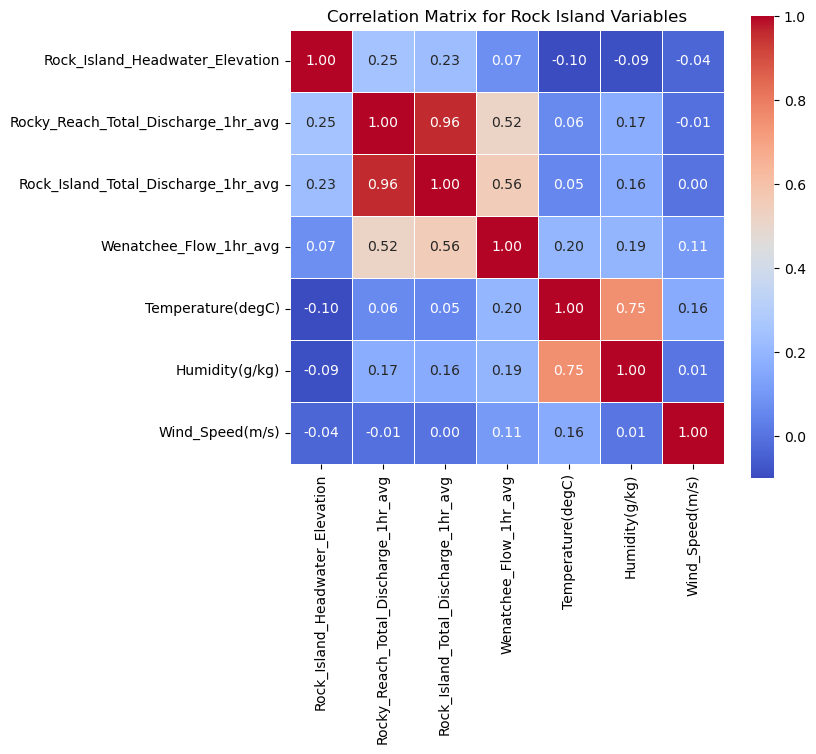

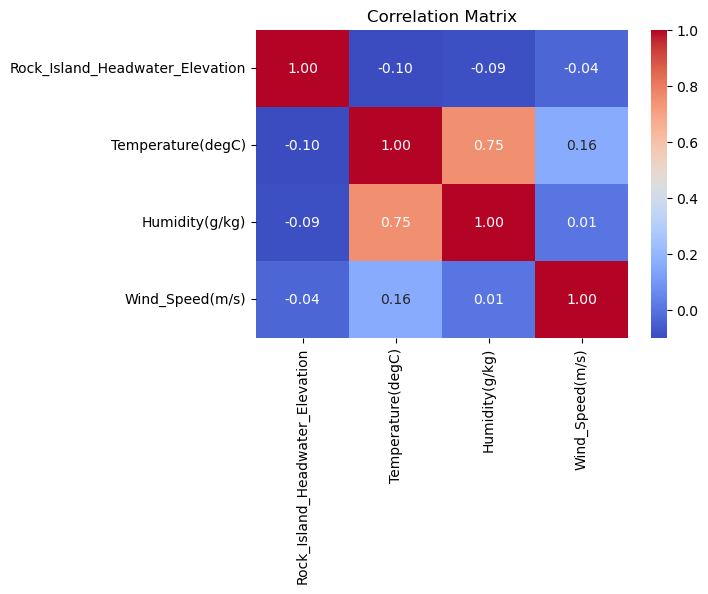

In [136]:
# Calculating the correlation matrix
corr_rocky_reach = data.corr()

# Setting up the matplotlib figure
plt.figure(figsize=(7, 6))
sns.heatmap(corr_rocky_reach, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)
plt.title('Correlation Matrix for Rock Island Variables')
plt.show()

# Compute correlation matrix
correlation_matrix = data[['Rock_Island_Headwater_Elevation', 'Temperature(degC)', 'Humidity(g/kg)', 'Wind_Speed(m/s)']].corr()
# Use seaborn to create a heatmap of the correlations
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

There is negative correlation between Rock Island Headwater Elevation and Weather data

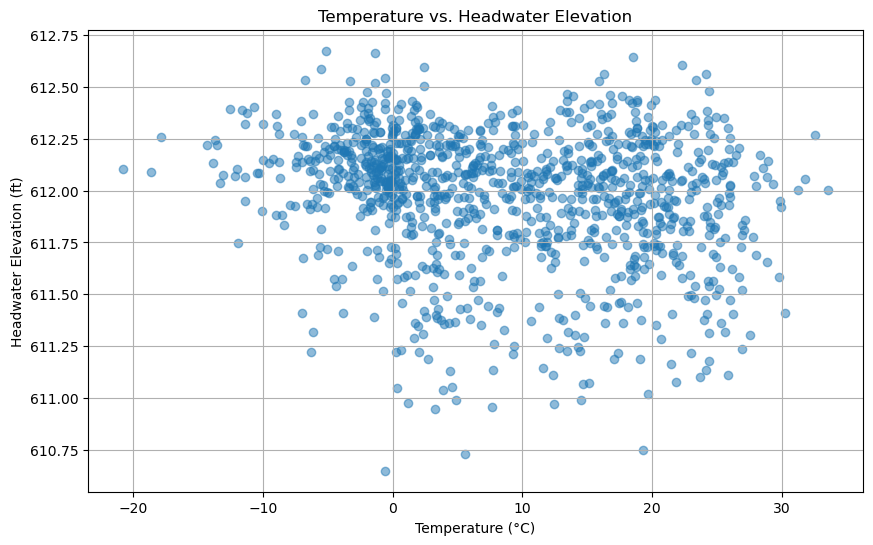

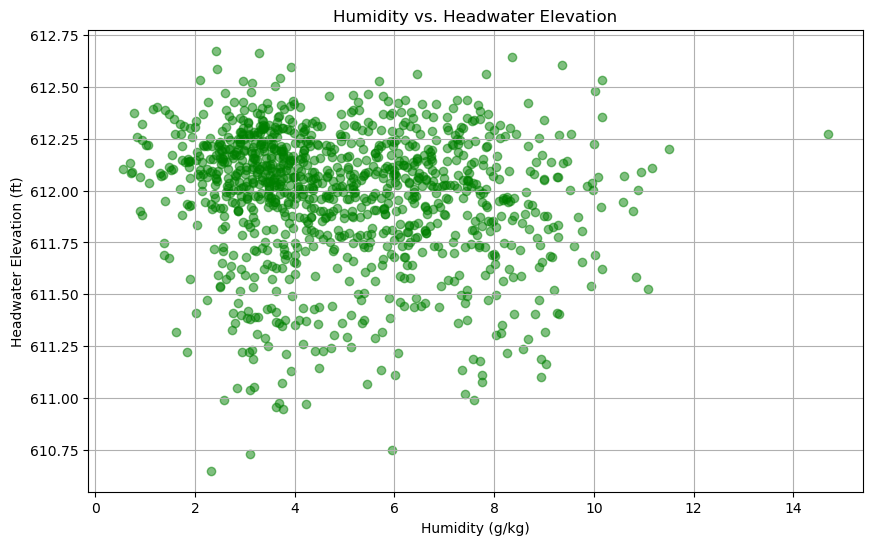

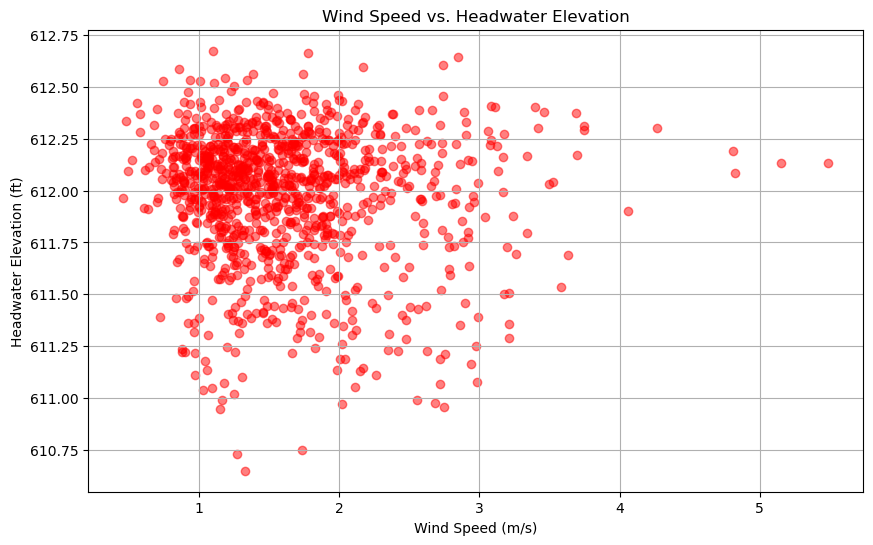

In [141]:
# Averaging for each date for plots
daily_data = data.resample('D').mean()

# Scatter plot of Temperature vs. Headwater Elevation
plt.figure(figsize=(10, 6))
plt.scatter(daily_data['Temperature(degC)'], daily_data['Rock_Island_Headwater_Elevation'], alpha=0.5)
plt.title('Temperature vs. Headwater Elevation')
plt.xlabel('Temperature (°C)')
plt.ylabel('Headwater Elevation (ft)')
plt.grid(True)
plt.show()

# Scatter plot of Humidity vs. Headwater Elevation
plt.figure(figsize=(10, 6))
plt.scatter(daily_data['Humidity(g/kg)'], daily_data['Rock_Island_Headwater_Elevation'], alpha=0.5, color='green')
plt.title('Humidity vs. Headwater Elevation')
plt.xlabel('Humidity (g/kg)')
plt.ylabel('Headwater Elevation (ft)')
plt.grid(True)
plt.show()

# Scatter plot of Wind Speed vs. Headwater Elevation
plt.figure(figsize=(10, 6))
plt.scatter(daily_data['Wind_Speed(m/s)'], daily_data['Rock_Island_Headwater_Elevation'], alpha=0.5, color='red')
plt.title('Wind Speed vs. Headwater Elevation')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Headwater Elevation (ft)')
plt.grid(True)
plt.show()

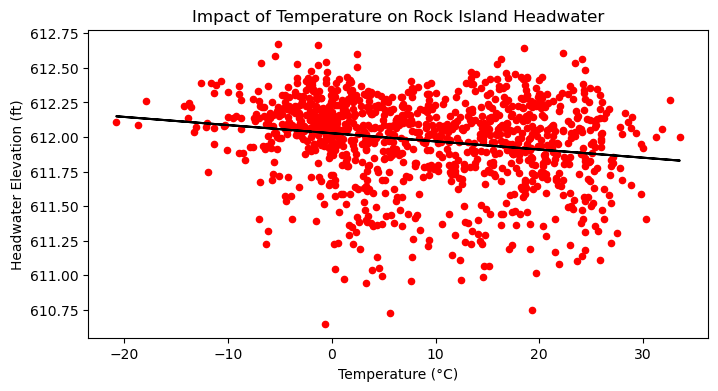

In [138]:
# Scatter plot of Temperature vs. Headwater Elevation with linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(daily_data['Temperature(degC)'], daily_data['Rock_Island_Headwater_Elevation'], color='red', s=20)

# Calculate the linear regression line
slope, intercept = np.polyfit(daily_data['Temperature(degC)'].dropna(), daily_data['Rock_Island_Headwater_Elevation'].dropna(), 1)
plt.plot(daily_data['Temperature(degC)'], slope * daily_data['Temperature(degC)'] + intercept, color='black')

# Plot enhancements
plt.title('Impact of Temperature on Rock Island Headwater')
plt.xlabel('Temperature (°C)')
plt.ylabel('Headwater Elevation (ft)')
plt.show()

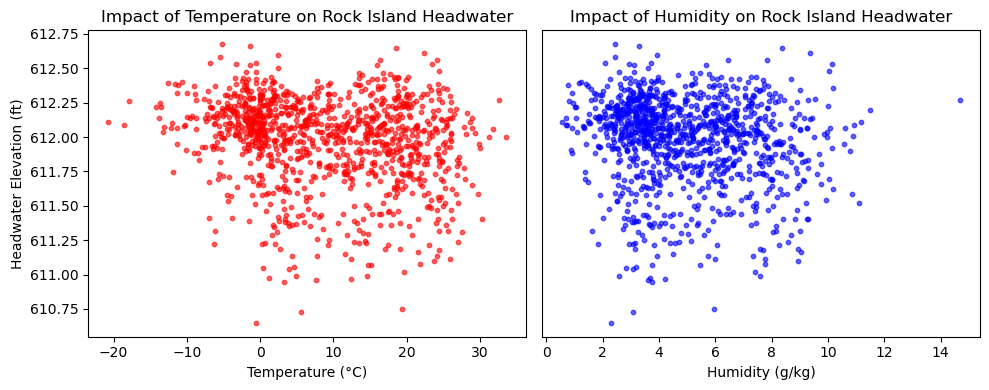

In [139]:
# Plotting side by side using subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Scatter plot of Temperature vs. Headwater Elevation
axs[0].scatter(daily_data['Temperature(degC)'], daily_data['Rock_Island_Headwater_Elevation'], color='red', alpha=0.6, s=10)
axs[0].set_title('Impact of Temperature on Rock Island Headwater')
axs[0].set_xlabel('Temperature (°C)')
axs[0].set_ylabel('Headwater Elevation (ft)')

# Scatter plot of Humidity vs. Headwater Elevation
axs[1].scatter(daily_data['Humidity(g/kg)'], daily_data['Rock_Island_Headwater_Elevation'], color='blue', alpha=0.6, s=10)
axs[1].set_title('Impact of Humidity on Rock Island Headwater')
axs[1].set_xlabel('Humidity (g/kg)')
axs[1].set_yticks([])

plt.tight_layout()
plt.show()

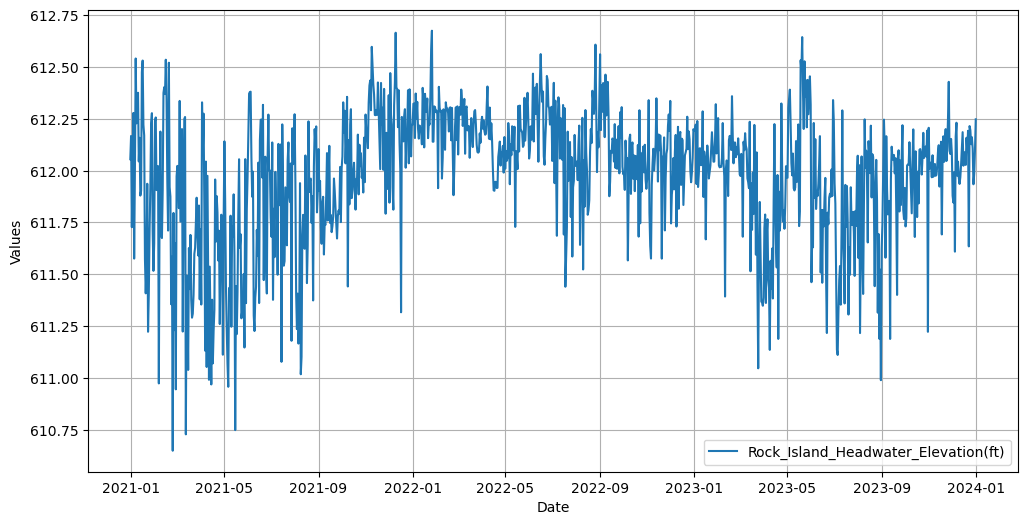

In [142]:
plt.figure(figsize=(12, 6))
# Resample the data to daily averages
daily_data = data.resample('D').mean()
plt.plot(daily_data.index, daily_data['Rock_Island_Headwater_Elevation'], label='Rock_Island_Headwater_Elevation(ft)')
plt.xlabel('Date')
plt.ylabel('Values')
plt.grid(True)
plt.legend()
plt.show()


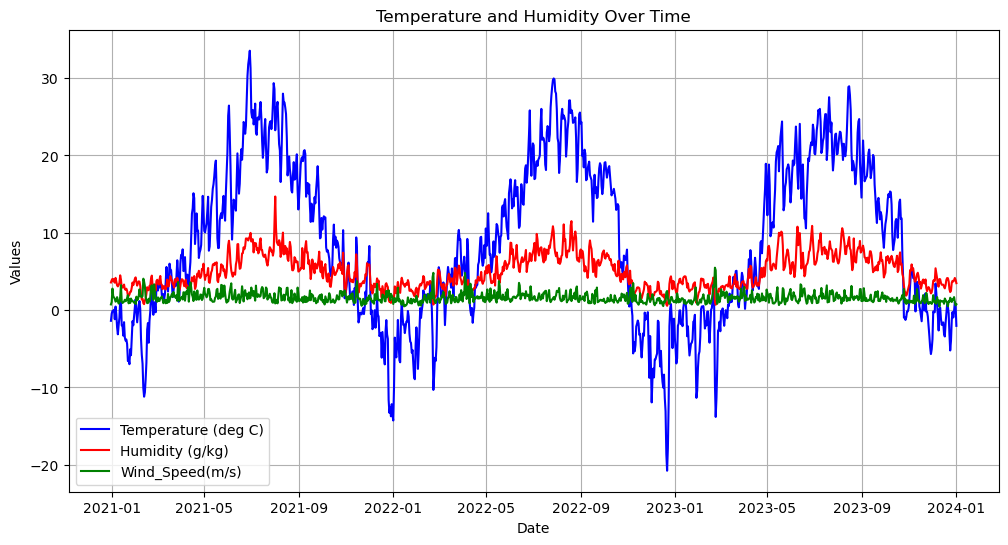

In [143]:
# Plotting Temperature and Humidity over time
plt.figure(figsize=(12, 6))
plt.plot(daily_data.index, daily_data['Temperature(degC)'], label='Temperature (deg C)', color='blue')
plt.plot(daily_data.index, daily_data['Humidity(g/kg)'], label='Humidity (g/kg)', color='red')
plt.plot(daily_data.index, daily_data['Wind_Speed(m/s)'], label='Wind_Speed(m/s)', color='green')
plt.title('Temperature and Humidity Over Time')
plt.xlabel('Date')
plt.ylabel('Values')
plt.grid(True)
plt.legend()
plt.show()

### 2.7.2. Feature Engineering, Feature Selection and Modeling

In [145]:
# Feature Engineering
# Adding lags for selected features

data['Rocky_Reach_Total_Discharge_1hr_avg_lag1'] = data['Rocky_Reach_Total_Discharge_1hr_avg'].shift(1)
data['Wenatchee_Flow_1hr_avg_lag1'] = data['Wenatchee_Flow_1hr_avg'].shift(1)

# Dropping rows with missing values after lagging
data.dropna(inplace=True)

# Separate features and target
target = 'Rock_Island_Headwater_Elevation'
X = data.drop(columns=[target]) 
y = data[target]  # Target

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Optimal Components is 7

In [146]:
pca = PCA(n_components=7) 
X_pca = pca.fit_transform(X_scaled)

# Using PCA components as input
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, shuffle=False)
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print("Mean Squared Error for Rock Island Dam:", mean_squared_error(y_test, y_pred))
print("R-Squared for Rock Island Dam:", r2_score(y_test, y_pred))

Mean Squared Error for Rock Island Dam: 0.1858259772951934
R-Squared for Rock Island Dam: 0.16164442299276638


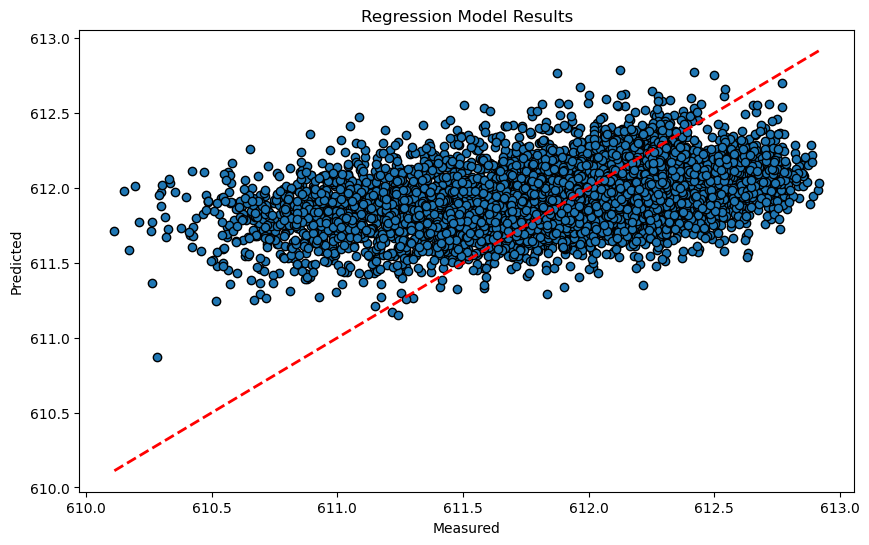

In [147]:
# Plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Regression Model Results')
plt.show()

## 2.8. Pricing Data Integration

### 2.8.1. Data Preparation and Merging

We will integrate pricing data into our model to improve the predictions.

In [169]:
df_rock_island = df.copy()

columns_to_drop = columns_to_drop = ['datetime_stamp', 'Wells_Total_Discharge',
                   'Chelan_Flow', 'Entiat_Flow', 'Rocky_Reach_Headwater_Elevation']

# Drop the unnecessary columns
df_rock_island = df_rock_island.drop(columns=columns_to_drop).copy()

In [170]:
pricing_data = pd.read_csv('caiso_pricing.csv')

columns_to_drop = ['Unnamed: 0','datetime']

# Drop the unnecessary columns
pricing_data = pricing_data.drop(columns=columns_to_drop).copy()

pricing_data.head()

datetime_utc     value
0  2022-05-03 07:00:00  72.28085
1  2022-05-03 07:05:00  61.95501
2  2022-05-03 07:10:00  61.95501
3  2022-05-03 07:15:00  72.16517
4  2022-05-03 07:20:00  51.54655

In [171]:
# Convert 'datetime_utc' to datetime format if not already done
df_rock_island['datetime_utc'] = pd.to_datetime(df_rock_island['datetime_utc'])

# Check minimum and maximum dates in the dataset
rock_island_start_date = df_rock_island['datetime_utc'].min()
rock_island_end_date = df_rock_island['datetime_utc'].max()

# Display the start and end dates
print("Rock Island Dataset Start Date:", rock_island_start_date)
print("Rock Island Dataset End Date:", rock_island_end_date)

Rock Island Dataset Start Date: 2019-01-01 08:00:00+00:00
Rock Island Dataset End Date: 2024-01-01 07:59:00+00:00


In [172]:
# Convert 'datetime_utc' to datetime format if not already done
pricing_data['datetime_utc'] = pd.to_datetime(pricing_data['datetime_utc'])

# Check minimum and maximum dates in the dataset
pricing_data_start_date = pricing_data['datetime_utc'].min()
pricing_data_end_date = pricing_data['datetime_utc'].max()

# Display the start and end dates
print("Pricing Dataset Start Date:", pricing_data_start_date)
print("Pricing Dataset End Date:", pricing_data_end_date)

Pricing Dataset Start Date: 2022-05-03 07:00:00
Pricing Dataset End Date: 2024-01-01 07:55:00


In [173]:
# Set the datetime index for both datasets
df_rock_island.set_index('datetime_utc', inplace=True)
pricing_data.set_index('datetime_utc', inplace=True)

# Remove timezone information from df_rock_island if it's timezone-aware
if df_rock_island.index.tz is not None:
    df_rock_island.index = df_rock_island.index.tz_localize(None)

# Similarly, ensure pricing_data is also timezone-naive
if pricing_data.index.tz is not None:
    pricing_data.index = pricing_data.index.tz_localize(None)

# Now try merging again
data = pd.merge(df_rock_island, pricing_data, left_index=True, right_index=True, how='inner')
data.head()

Rocky_Reach_Total_Discharge  Wenatchee_Flow  \
datetime_utc                                                       
2022-05-03 07:00:00                    54.303470        3.963931   
2022-05-03 07:05:00                    54.495838        3.965166   
2022-05-03 07:10:00                    39.110930        3.966400   
2022-05-03 07:15:00                    30.863651        3.967635   
2022-05-03 07:20:00                    30.643172        3.968869   

                     Rock_Island_Total_Discharge  \
datetime_utc                                       
2022-05-03 07:00:00                   110.351645   
2022-05-03 07:05:00                    86.034776   
2022-05-03 07:10:00                    78.113307   
2022-05-03 07:15:00                   100.976425   
2022-05-03 07:20:00                    90.190205   

                     Rock_Island_Headwater_Elevation     value  
datetime_utc                                                    
2022-05-03 07:00:00                       612.130286  72.28085  
2022-05-03 07:05:00                       612.364825  61.95501  
2022-05-03 07:10:00                       612.524474  61.95501  
2022-05-03 07:15:00                       612.312604  72.16517  
2022-05-03 07:20:00                       612.437496  51.54655

In [174]:
print("Combined Data Shape:", data.shape)
# Additional checks for alignment and data integrity
print("Combined Dataset Start Date:", data.index.min())
print("Combined Dataset End Date:", data.index.max())

Combined Data Shape: (173964, 5)
Combined Dataset Start Date: 2022-05-03 07:00:00
Combined Dataset End Date: 2024-01-01 07:55:00


### 2.8.2. Checking Relationship between Pricing Data and Rock Island

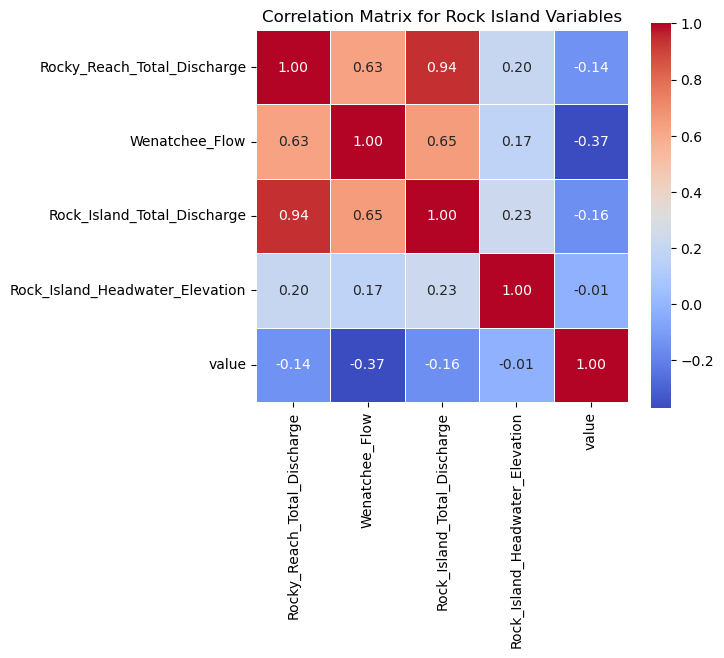

In [175]:
# Calculating the correlation matrix
corr_rock_island = data.corr()

# Setting up the matplotlib figure
plt.figure(figsize=(6, 5))
sns.heatmap(corr_rock_island, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)
plt.title('Correlation Matrix for Rock Island Variables')
plt.show()

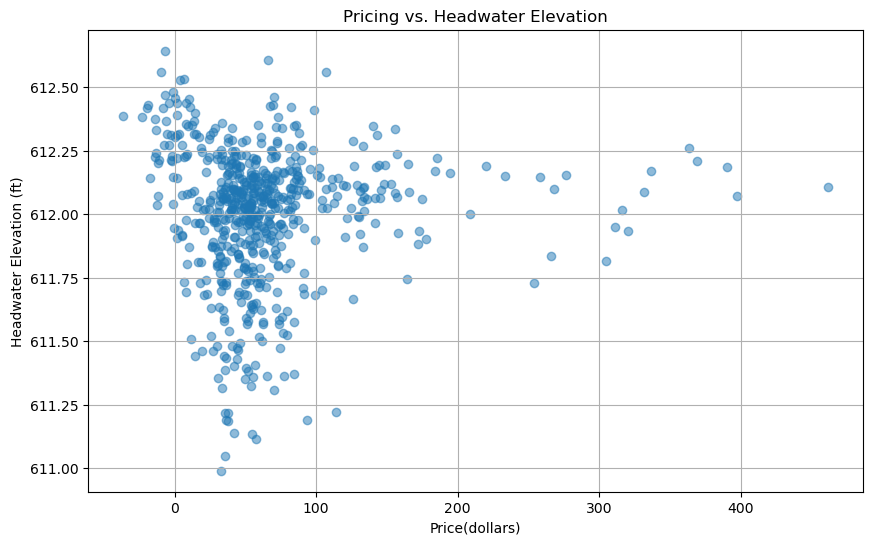

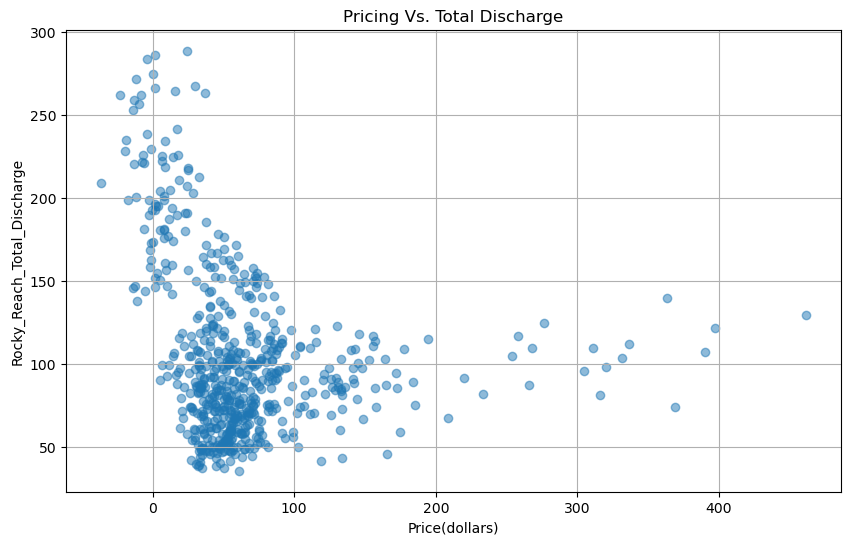

In [176]:
# Averaging for each date for plots
daily_data = data.resample('D').mean()

# Scatter plot of Price vs. Headwater Elevation
plt.figure(figsize=(10, 6))
plt.scatter(daily_data['value'], daily_data['Rock_Island_Headwater_Elevation'], alpha=0.5)
plt.title('Pricing vs. Headwater Elevation')
plt.xlabel('Price(dollars)')
plt.ylabel('Headwater Elevation (ft)')
plt.grid(True)
plt.show()

# Scatter plot of Price vs. Total Discharge
plt.figure(figsize=(10, 6))
plt.scatter(daily_data['value'], daily_data['Rock_Island_Total_Discharge'], alpha=0.5)
plt.title('Pricing Vs. Total Discharge')
plt.xlabel('Price(dollars)')
plt.ylabel('Rocky_Reach_Total_Discharge')
plt.grid(True)
plt.show()

#### 5-min Data

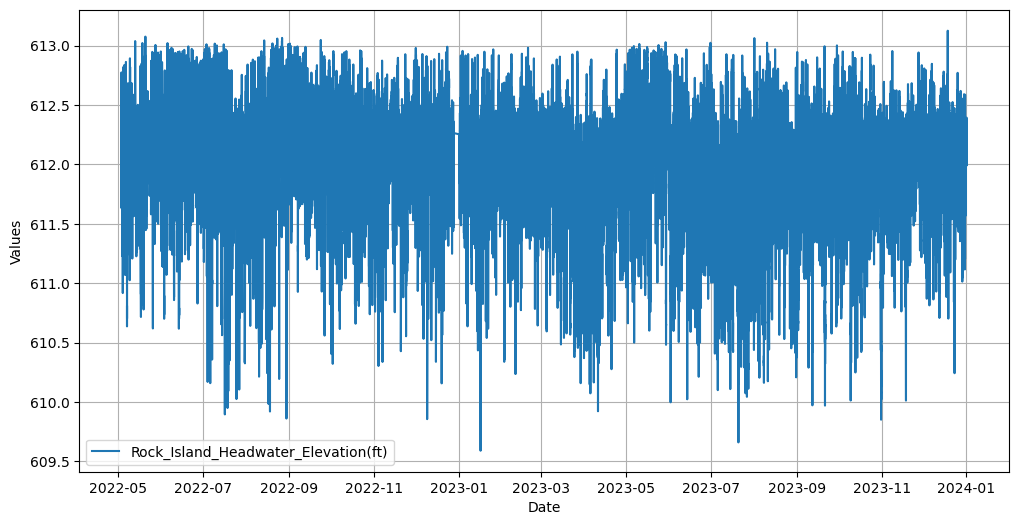

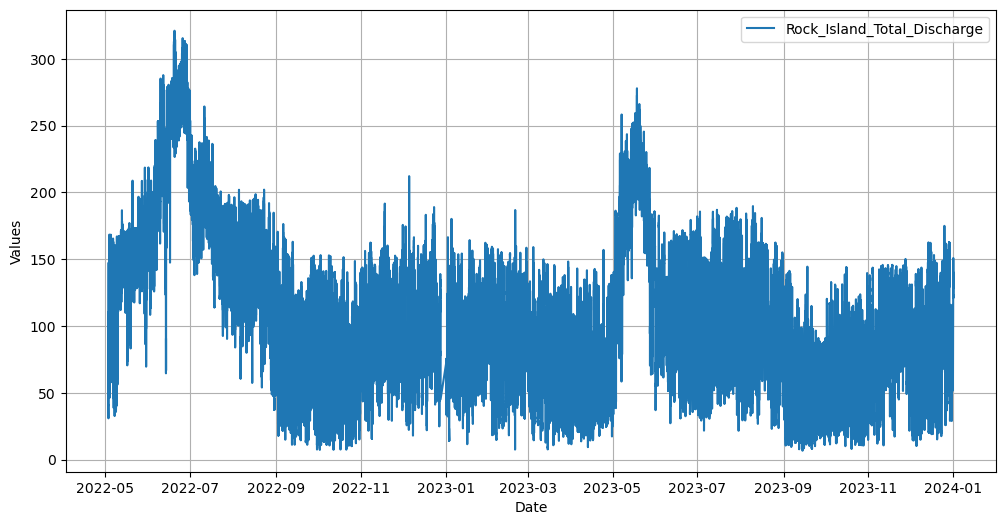

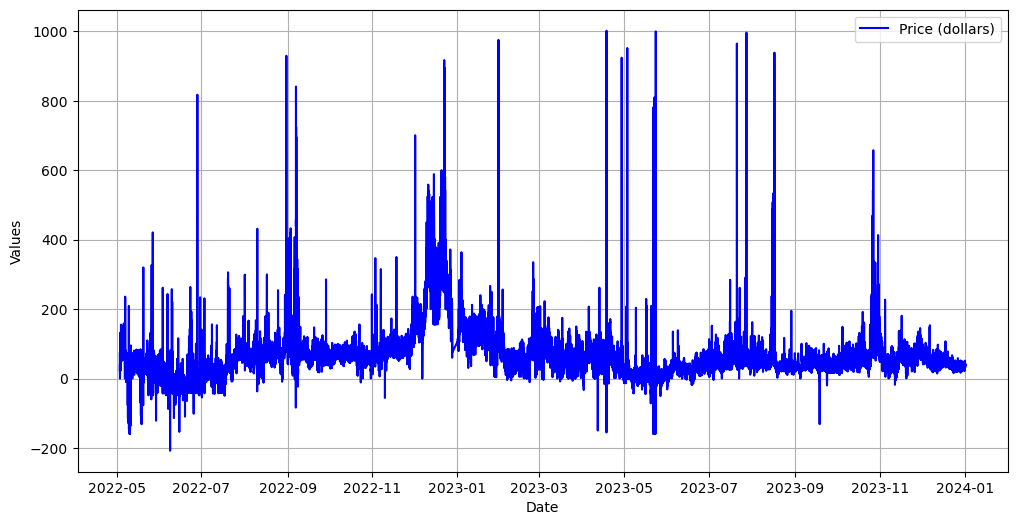

In [177]:
# Plotting Rock Island Headwater Elevation Over Time
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Rock_Island_Headwater_Elevation'], label='Rock_Island_Headwater_Elevation(ft)')
plt.xlabel('Date')
plt.ylabel('Values')
plt.grid(True)
plt.legend()
plt.show()


# Plotting Rock Island Total Discharge Over Time
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Rock_Island_Total_Discharge'], label='Rock_Island_Total_Discharge')
plt.xlabel('Date')
plt.ylabel('Values')
plt.grid(True)
plt.legend()
plt.show()

# Plotting Price Over Time
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['value'], label='Price (dollars)', color='blue')
plt.xlabel('Date')
plt.ylabel('Values')
plt.grid(True)
plt.legend()
plt.show()

#### Daily Data

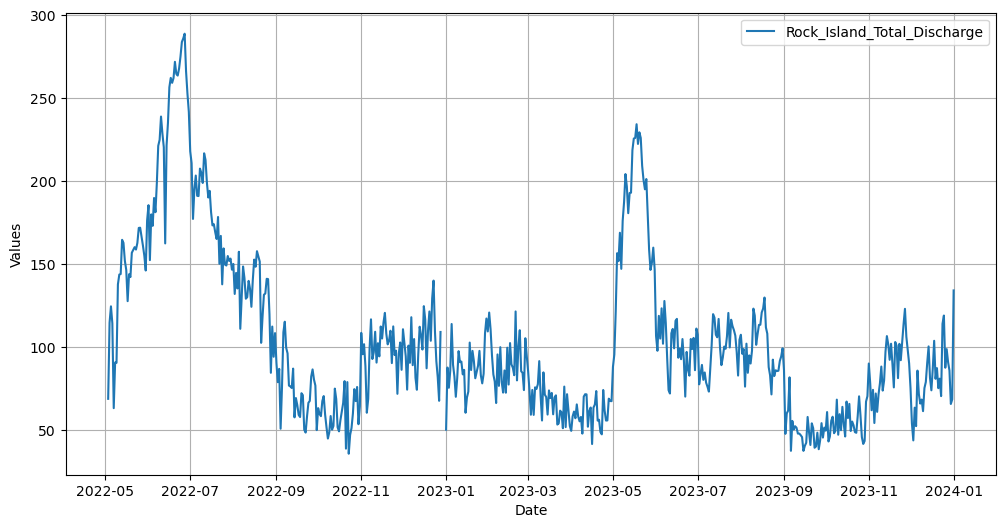

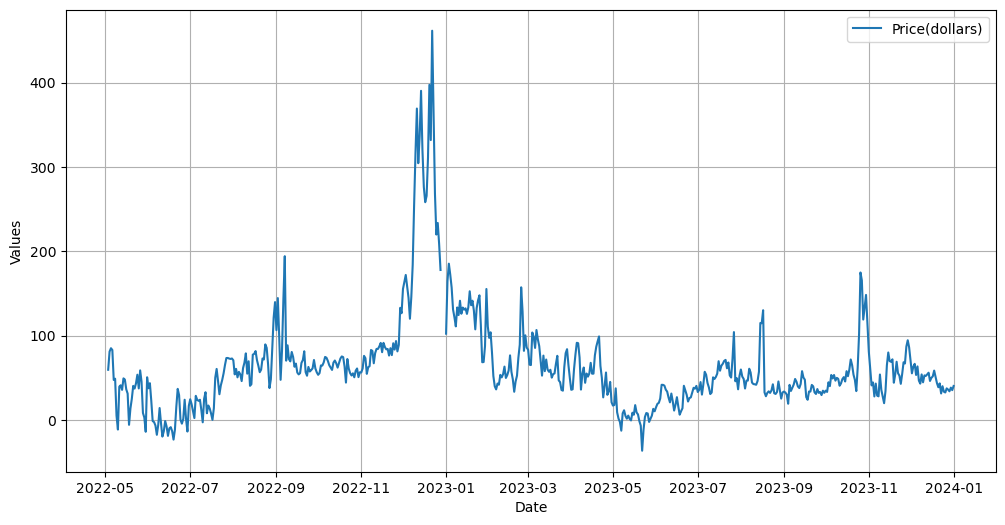

In [178]:
# Resample the data to daily averages
daily_data = data.resample('D').mean()
plt.figure(figsize=(12, 6))
plt.plot(daily_data.index, daily_data['Rock_Island_Total_Discharge'], label='Rock_Island_Total_Discharge')
plt.xlabel('Date')
plt.ylabel('Values')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(daily_data.index, daily_data['value'], label='Price(dollars)')
plt.xlabel('Date')
plt.ylabel('Values')
plt.grid(True)
plt.legend()
plt.show()

### 2.8.2. Feature Engineering, Feature Selection and Modeling

In [180]:
# Create time-based features
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['month'] = data.index.month

# Rolling window features (example for a 20-minute window)
data['price_rolling_mean_20'] = data['value'].rolling(window=4).mean()  # since data is in 5-minute intervals
data['discharge_rolling_mean_20'] = data['Rock_Island_Total_Discharge'].rolling(window=4).mean()

# Lagged pricing features
for lag in range(1, 5):  # lag up to 20 minutes
    data[f'price_lag_{lag}'] = data['value'].shift(lag)

data.bfill(inplace = True)
data.ffill(inplace = True)

X = data.drop(['Rock_Island_Total_Discharge'], axis=1)
y = data['Rock_Island_Total_Discharge']  # You can change this to fill rate

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Optimal Components = 10

In [181]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, shuffle=False)

# Model training with Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-Squared:", r2_score(y_test, y_pred))

Mean Squared Error: 23.584756250666697
R-Squared: 0.984220896397193


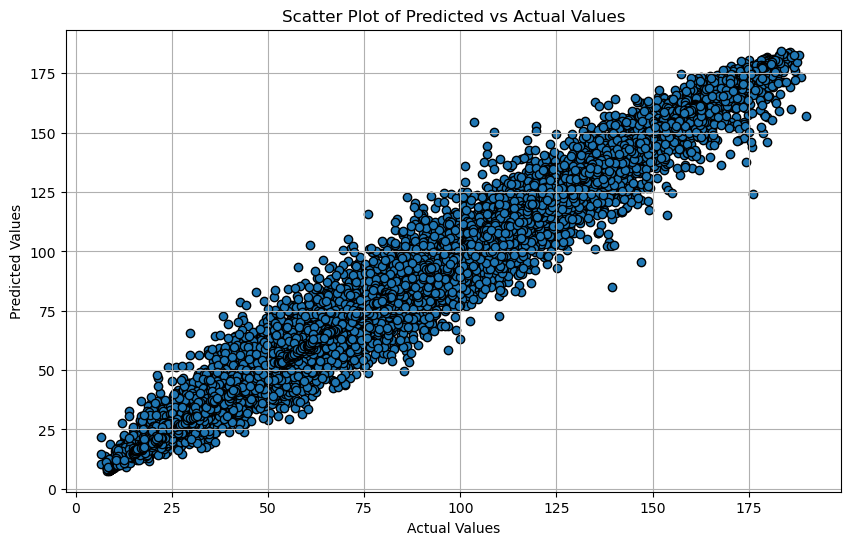

In [182]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, edgecolors='k')
plt.title('Scatter Plot of Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

In [183]:
# Features from the data
feature_names = X.columns

# Components given by pca
components = pca.components_

# Function to get top features for each component
def get_top_features_for_component(component, num_features):
    sorted_feature_indices = np.argsort(np.abs(component))[::-1][:num_features]
    return feature_names[sorted_feature_indices]

# Getting top 10 features for each component
num_top_features = 10 
top_features_per_component = {}

for i, component in enumerate(components):
    top_features = get_top_features_for_component(component, num_top_features)
    top_features_per_component[f"Component {i+1}"] = top_features

# Counting how often each feature appears in the top lists
feature_counts = pd.Series(np.concatenate(list(top_features_per_component.values()))).value_counts()

# Displaying the most frequently appearing features
print("Most Influential Features in PCA:")
print(feature_counts.head(10))

Most Influential Features in PCA:
price_rolling_mean_20              10
price_lag_1                        10
discharge_rolling_mean_20          10
Rocky_Reach_Total_Discharge        10
Wenatchee_Flow                      9
month                               8
hour                                8
value                               7
Rock_Island_Headwater_Elevation     7
price_lag_2                         6
Name: count, dtype: int64
